In [69]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [70]:
import eigen_analysis

cols = eigen_analysis.LINUX_COLS
time_unit = eigen_analysis.TIME_CONVERSION_khz
joules_unit = eigen_analysis.JOULE_CONVERSION

In [71]:
# get all itrs explored for some (dvfs, qps) pair
def list_itrs(rdtsc_dirname):
    itrs = []
    for file in os.listdir(rdtsc_dirname):
        tags = file.split('_')
        itr = tags[1]
        itrs.append(itr)
    itrs = list(set(itrs))
    return itrs

In [72]:
def print_err_log(dvfs, qps, itr, rapl='135', run='0', err_dir = 'err_logs/'):
    err_filename = 'err_log_' + run + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps[:-1] + '000'
    if os.path.exists(err_dir + err_filename):
        err_file = open(err_dir + err_filename, 'r')
        print(err_file.read())
    else:
        print('EMPTY ERROR LOG')

In [73]:
def handle_neg_diffs(df_diffs, df, core, err_file):
    
    tmp = df_diffs.copy()

    # isolating rows with negative diffs
    tmp_neg = tmp[(tmp['joules_diff'] < 0) | (tmp['instructions_diff'] < 0) | (tmp['cycles_diff'] < 0) \
                   | (tmp['ref_cycles_diff'] < 0) | (tmp['llc_miss_diff'] < 0) | (tmp['timestamp_diff'] < 0)]

    # re-computing diffs if possible; else dropping rows
    for i,j in tmp_neg.iterrows():
        prev = df.shift(1).loc[i]
        cur = df.loc[i]
        # TODO note that we are only handling case of RAPL-energy-status register overflow
        if (tmp.loc[i]['joules_diff'] < 0) & (tmp.loc[i]['timestamp_diff'] >= 0.001):
            err_file.write('CORE ' + str(core) + '  ---  JOULES COUNTER OVERFLOW AT LOG ENTRY DIFF #' + str(i) + '\n')
            tmp.loc[i, ['joules_diff']] = (2**32 - 1) * joules_unit - prev['joules'] + cur['joules'] 
        else:
            err_file.write('CORE ' + str(core) + '  ---  UNEXPLAINED NEGATIVE VALS AT LOG ENTRY DIFF # ' + str(i) + '\n')
            cols = ''
            prevs = ''
            currs = ''
            for col in list(df.columns):
                cols += col + '  '
                prevs += str(prev[col]) + '  '
                currs += str(cur[col]) + '  '
            err_file.write('          ' + cols + '\n')
            err_file.write('         log[' + str(i-1) + ']: ' + prevs + '\n')
            err_file.write('         log[' + str(i) + ']: ' + currs + '\n')
            tmp = tmp.drop(i, axis=0)

    return tmp

### Correlation matrices and eigenvals:

In [74]:
def per_core_corr(dvfs, qps, itr, app, rapl='135', run='0'):

    app_dir = app + '_' + run + '_rapl_' + rapl + '/'
    corr_dir = app_dir + qps + '_corr/'
    counters_corr_outdir = corr_dir + qps + '_' + dvfs + '_counters_corr/'
    non_counters_corr_outdir = corr_dir + qps + '_' + dvfs + '_non_counters_corr/'
    !mkdir -p $counters_corr_outdir
    !mkdir -p $non_counters_corr_outdir
    
    logs_dir = app_dir + qps + '_qps/linux_' + app + '_dmesg_' + run + '_' + dvfs + '_' + rapl + '_' + qps + '/'
    rdtsc_dir = app_dir + qps + '_qps/linux_' + app + '_rdtsc_' + run + '_' + dvfs + '_' + rapl + '_' + qps +'/'
    rdtsc_file = rdtsc_dir + 'linux.' + app + '.rdtsc.' + run + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps[:-1] + '000'
    start, end = eigen_analysis.get_rdtsc(rdtsc_file)

    err_dir = app_dir + 'err_logs/'
    err_filename = 'err_log_' + run + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps[:-1] + '000'
    err_file = open(err_dir + err_filename, 'w')

    counters_corr_dict = {}
    non_counters_corr_dict = {}
    
    cores = []
    cores = !ls $logs_dir | cut -d '_' -f2 | sort | uniq
    for c in cores:
        counters_corr_outfile = counters_corr_outdir + dvfs + '_' + qps + '_' + itr + '_counters_' + c + '_corr'
        non_counters_corr_outfile = non_counters_corr_outdir + dvfs + '_' + qps + '_' + itr + '_non_counters_' + c + '_corr'

        # check if corr matrices have been precomputed
        if os.path.exists(counters_corr_outfile):
            counters_corr = pd.read_csv(counters_corr_outfile, index_col=0)
            counters_corr_dict[str(c)] = counters_corr
            if os.path.exists(non_counters_corr_outfile):
                non_counters_corr = pd.read_csv(non_counters_corr_outfile, index_col=0)
                non_counters_corr_dict[str(c)] = non_counters_corr
                continue
        
        # otherwise, compute corr matrices
        logs_file = logs_dir + 'linux.' + app + '.dmesg.' + run + '_' + str(c) + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps[:-1] + '000'
        !gunzip -v $logs_file'.gz'    
        df = pd.read_csv(logs_file, sep = ' ', names = cols, index_col='i')
        !gzip -v9 $logs_file
        
        df = df[(df['timestamp'] >= start) & (df['timestamp'] <= end)]
        df.loc[:, 'timestamp'] = df['timestamp'] - df['timestamp'].min()
        df.loc[:, 'timestamp'] = df['timestamp'] * time_unit
        df.loc[:, 'joules'] = df['joules'] * joules_unit
        
        counters_df = df[['joules', 'instructions', 'cycles', 'ref_cycles', 'llc_miss', 'timestamp']].copy()
        counters_df = counters_df[(counters_df['joules'] > 0) & (counters_df['instructions'] > 0) \
                                            & (counters_df['cycles'] > 0) & (counters_df['ref_cycles'] > 0) \
                                            & (counters_df['llc_miss'] > 0)]
        df_diffs = counters_df.diff().dropna().copy()
        df_diffs.columns = [f'{c}_diff' for c in df_diffs.columns]
        df_diffs = handle_neg_diffs(df_diffs, counters_df, c, err_file)
        counters_corr = df_diffs.drop(['timestamp_diff', 'joules_diff'], axis = 1).corr()

        non_counters_df = df[['rx_bytes', 'rx_desc', 'tx_bytes', 'tx_desc']].copy()
        non_counters_corr = non_counters_df.corr()

        # saving corr matrix
        counters_corr_dict[str(c)] = counters_corr
        non_counters_corr_dict[str(c)] = non_counters_corr
        counters_corr.to_csv(counters_corr_outfile)
        non_counters_corr.to_csv(non_counters_corr_outfile)
        
    return counters_corr_dict, non_counters_corr_dict

In [75]:
def merged_core_corr(dvfs, qps, itr, app, rapl='135', run='0'):
    app_dir = app + '_' + run + '_rapl_' + rapl + '/'
    merged_dir = app_dir + qps + '_merged/'
    corr_dir = app_dir + qps + '_merged_corr/'
    counters_corr_outdir = corr_dir + qps + '_' + dvfs + '_counters_merged_corr/'
    !mkdir -p $counters_corr_outdir
    non_counters_corr_outdir = corr_dir + qps + '_' + dvfs + '_non_counters_merged_corr/'
    !mkdir -p $non_counters_corr_outdir
    counters_corr_outfile = counters_corr_outdir + dvfs + '_' + qps + '_' + itr + '_counters_merged_corr'
    non_counters_corr_outfile = non_counters_corr_outdir + dvfs + '_' + qps + '_' + itr + '_non_counters_merged_corr'
    
    # check if corr matrices have been precomputed
    if os.path.exists(counters_corr_outfile):
        counters_corr = pd.read_csv(counters_corr_outfile, index_col=0)
        if os.path.exists(non_counters_corr_outfile):
            non_counters_corr = pd.read_csv(non_counters_corr_outfile, index_col=0)
            return counters_corr, non_counters_corr
        
    merged_counters_dir = merged_dir + qps + '_' + dvfs + '_counters_merged/'
    merged_non_counters_dir = merged_dir + qps + '_' + dvfs + '_non_counters_merged/'
    merged_counters_file = merged_counters_dir + dvfs + '_' + qps + '_' + itr + '_counters_merged'
    merged_non_counters_file = merged_non_counters_dir + dvfs + '_' + qps + '_' + itr + '_non_counters_merged'
    
    # check if merged log has been precomputed, bail if not
    if not (os.path.exists(merged_counters_file) or (os.path.exists(merged_counters_file + '.gz')) \
            or os.path.exists(merged_non_counters_file) or (os.path.exists(merged_non_counters_file + '.gz'))):
        counters_corr = pd.DataFrame()
        non_counters_corr = pd.DataFrame()        
        return counters_corr, non_counters_corr
    
    !gunzip -v $merged_counters_file'.gz'    
    !gunzip -v $merged_non_counters_file'.gz'
    
    counters_df = pd.read_csv(merged_counters_file, index_col=0)
    non_counters_df = pd.read_csv(merged_non_counters_file, index_col=0)
    counters_corr = counters_df.drop(['timestamp', 'joules_diff'], axis = 1).corr()
    non_counters_corr = non_counters_df.drop(['timestamp'], axis = 1).corr()
        
    # saving corr matrix
    counters_corr.to_csv(counters_corr_outfile)
    non_counters_corr.to_csv(non_counters_corr_outfile)    
    
    !gzip -v9 $merged_counters_file    
    !gzip -v9 $merged_non_counters_file    
    
    return counters_corr, non_counters_corr

In [76]:
from numpy.linalg import eig, eigvalsh

def get_per_core_eigvals(cores, dvfs, qps, itr, app, rapl='135', run='0'):
    
    app_dir = app + '_' + run + '_rapl_' + rapl + '/'
    corr_dir = app_dir + qps + '_corr/'
    counters_corr_dir = corr_dir + qps + '_' + dvfs + '_counters_corr/'
    non_counters_corr_dir = corr_dir + qps + '_' + dvfs + '_non_counters_corr/'

    counters_corr_dict = {}
    non_counters_corr_dict = {}
    all_core_eigvals = {}
    for c in cores:
        counters_corr_file = counters_corr_dir + dvfs + '_' + qps + '_' + itr + '_counters_' + c + '_corr'
        counters_corr_dict[c] = pd.read_csv(counters_corr_file, index_col=0)
        counter_vals, vecs = eig(counters_corr_dict[str(c)])
        for i in range(0, len(counter_vals)):
            counter_vals[i] = counter_vals[i] / counter_vals[0]
        non_counters_corr_file = non_counters_corr_dir + dvfs + '_' + qps + '_' + itr + '_non_counters_' + c + '_corr'
        non_counters_corr_dict[c] = pd.read_csv(non_counters_corr_file, index_col=0)
        non_counter_vals, vecs = eig(non_counters_corr_dict[str(c)])
        for i in range(0, len(non_counter_vals)):
            non_counter_vals[i] = non_counter_vals[i] / non_counter_vals[0]
        all_core_eigvals[str(c)] = np.concatenate([np.log(counter_vals[1:4]) , np.log(non_counter_vals[1:4])])

    return all_core_eigvals
        
def get_merged_eigvals(dvfs, qps, itr, app, rapl='135', run='0'):
    
    app_dir = app + '_' + run + '_rapl_' + rapl + '/'
    corr_dir = app_dir + qps + '_merged_corr/'
    merged_counters_corr_dir = corr_dir + qps + '_' + dvfs + '_counters_merged_corr/'
    merged_non_counters_corr_dir = corr_dir + qps + '_' + dvfs + '_non_counters_merged_corr/'
    
    merged_counters_corr_file = merged_counters_corr_dir + dvfs + '_' + qps + '_' + itr + '_counters_merged_corr'
    merged_counters_corr = pd.read_csv(merged_counters_corr_file, index_col=0)
    merged_counter_vals, merged_vecs = eig(merged_counters_corr)
    for i in range(0, len(merged_counter_vals)):
        merged_counter_vals[i] = merged_counter_vals[i] / merged_counter_vals[0]
    merged_non_counters_corr_file = merged_non_counters_corr_dir + dvfs + '_' + qps + '_' + itr + '_non_counters_merged_corr'
    merged_non_counters_corr = pd.read_csv(merged_non_counters_corr_file, index_col=0)
    merged_non_counter_vals, merged_vecs = eig(merged_non_counters_corr)
    for i in range(0, len(merged_non_counter_vals)):
        merged_non_counter_vals[i] = merged_non_counter_vals[i] / merged_non_counter_vals[0]    
    merged_eigvals = np.concatenate([np.log(merged_counter_vals[1:4]), np.log(merged_non_counter_vals[1:4])])
    
    return merged_eigvals

In [121]:
def plot_eig_vals(eig_dict, dvfs, qps, itr, app):
    plt.figure(figsize=(10,6))
    num_eig = len(list(eig_dict.values())[0])
    eig_list = [str(i) for i in range(0, num_eig)]
    for core in eig_dict.keys():   
        vals = eig_dict[core]
        if core == 'merged':
            plt.plot(eig_list, vals, 'x', label='merged') 
        else:
            plt.plot(eig_list, vals, 'p', label='core ' + str(core))
    plt.xlabel('eigval id')
    plt.ylabel('log( eigval / max_eigval )')
    plt.ylim(-20)
    plt.title(f'{app}: Eigvals of Per-Core and Merged Corr Matrices (ITR-DELAY = {itr}, DVFS = {dvfs}, QPS = {qps})')
    #plt.title(f'{app}: Eigvals of Merged Corr Matrix (ITR-DELAY = {itr}, DVFS = {dvfs}, QPS = {qps})')
    plt.legend()
    plt.savefig(app_dir + 'plots/eigvals_'+ dvfs + '_' + qps + '_' + itr)
    plt.show()


In [122]:
# def plot_corr(eig_dict, dvfs, qps, itr, app):
#     plt.figure(figsize=(10,6))
#     num_eig = len(list(eig_dict.values())[0])
#     eig_list = [str(i) for i in range(0, num_eig)]
#     for core in eig_dict.keys():   
#         vals = eig_dict[core]
#         if core == 'merged':
#             plt.plot(eig_list, vals, 'x', label='merged') 
#         else:
#             plt.plot(eig_list, vals, 'p', label='core ' + str(core))
#     plt.xlabel('eigval id')
#     plt.ylabel('log( eigval / max_eigval )')
#     #plt.ylim(-20)
#     plt.title(f'{app}: Eigvals of Per-Core and Merged Corr Matrices (ITR-DELAY = {itr}, DVFS = {dvfs}, QPS = {qps})')
#     #plt.title(f'{app}: Eigvals of Merged Corr Matrix (ITR-DELAY = {itr}, DVFS = {dvfs}, QPS = {qps})')
#     plt.legend()
#     plt.savefig(app_dir + 'plots/eigvals_'+ dvfs + '_' + qps + '_' + itr)
#     plt.show()


In [131]:
app = 'mcd'
run = '0'
rapl = '135'
dvfs = '0x1d00'
qps = '75k'

In [132]:
app_dir = app + '_' + run + '_rapl_' + rapl + '/'
logs_dir = app_dir + qps + '_qps/linux_' + app + '_dmesg_' + run + '_' + dvfs + '_' + rapl + '_' + qps + '/'
rdtsc_dir = app_dir + qps + '_qps/linux_' + app + '_rdtsc_' + run + '_' + dvfs + '_' + rapl + '_' + qps +'/'
itrs = list_itrs(rdtsc_dir)
cores = []
cores = !ls $logs_dir | cut -d '_' -f2 | sort | uniq

In [133]:
print(app_dir)
print(logs_dir)
print(rdtsc_dir)
print(f'cores: {cores}')
print(f'itrs: {itrs}')

mcd_0_rapl_135/
mcd_0_rapl_135/75k_qps/linux_mcd_dmesg_0_0x1d00_135_75k/
mcd_0_rapl_135/75k_qps/linux_mcd_rdtsc_0_0x1d00_135_75k/
cores: ['0', '1', '10', '11', '12', '13', '14', '15', '2', '3', '4', '5', '6', '7', '8', '9']
itrs: ['300', '30', '2', '400', '4', '40', '10', '50', '20', '200', '100']



ITR-DELAY = 300,   DVFS = 0xd00,    QPS = 75k


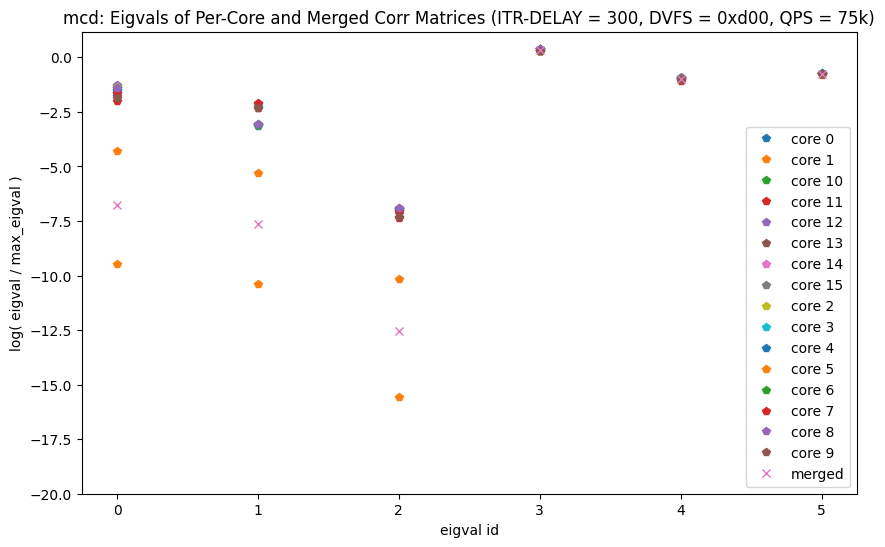


ITR-DELAY = 30,   DVFS = 0xd00,    QPS = 75k


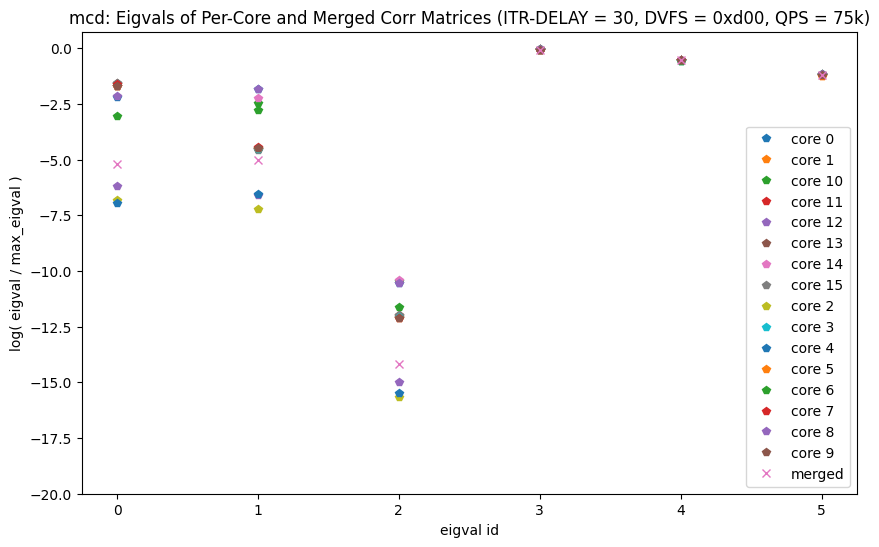


ITR-DELAY = 2,   DVFS = 0xd00,    QPS = 75k


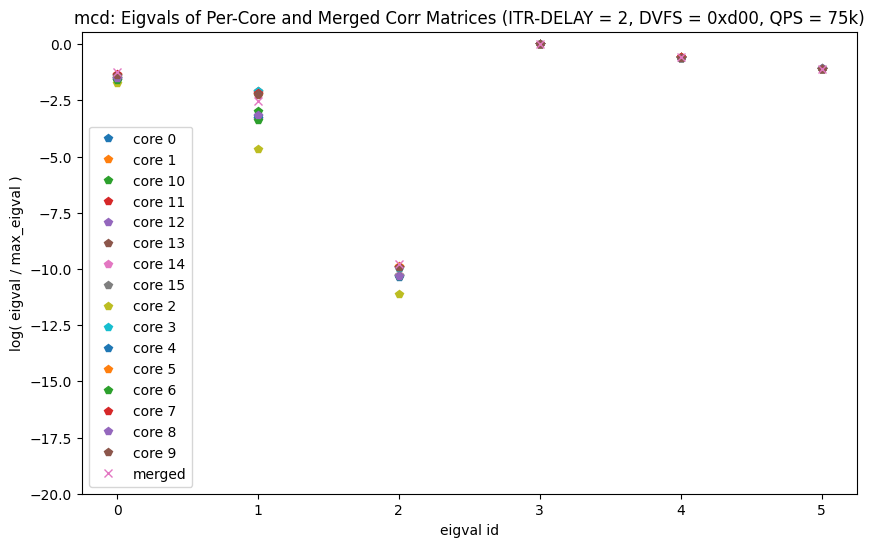


ITR-DELAY = 400,   DVFS = 0xd00,    QPS = 75k


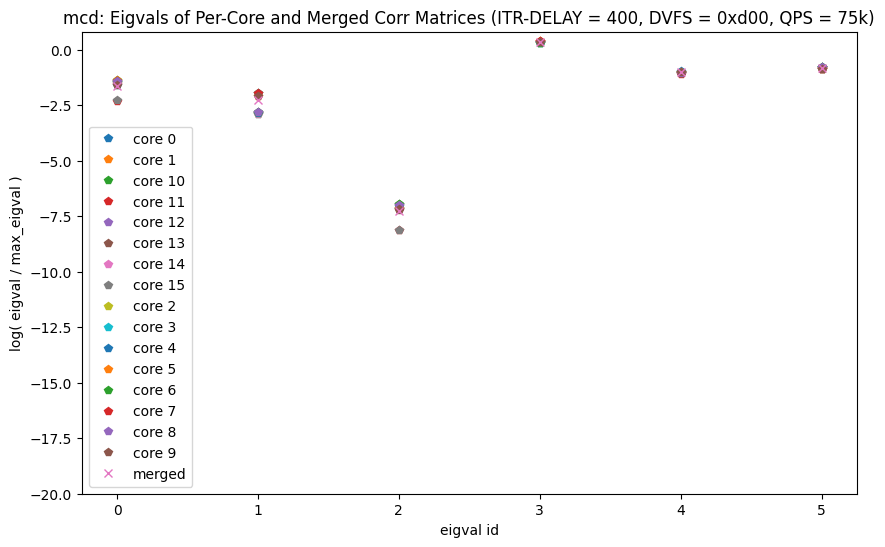


ITR-DELAY = 4,   DVFS = 0xd00,    QPS = 75k


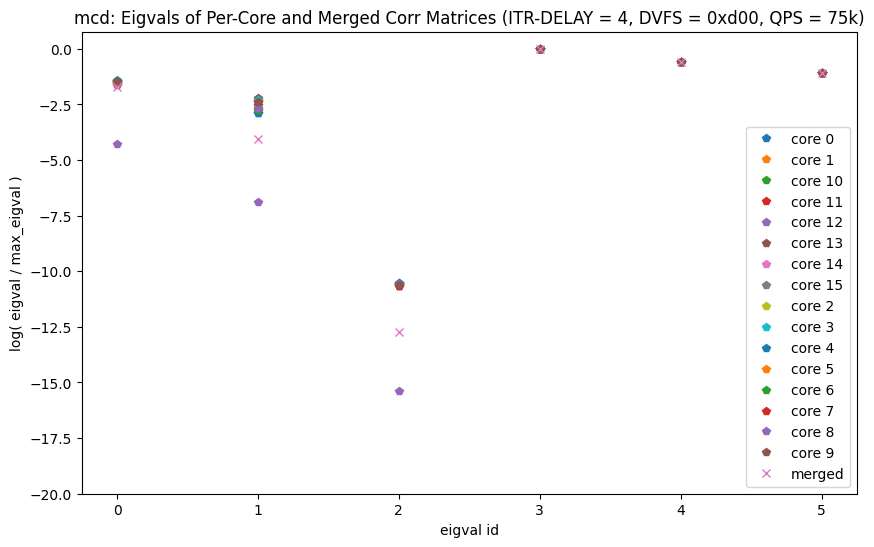


ITR-DELAY = 40,   DVFS = 0xd00,    QPS = 75k


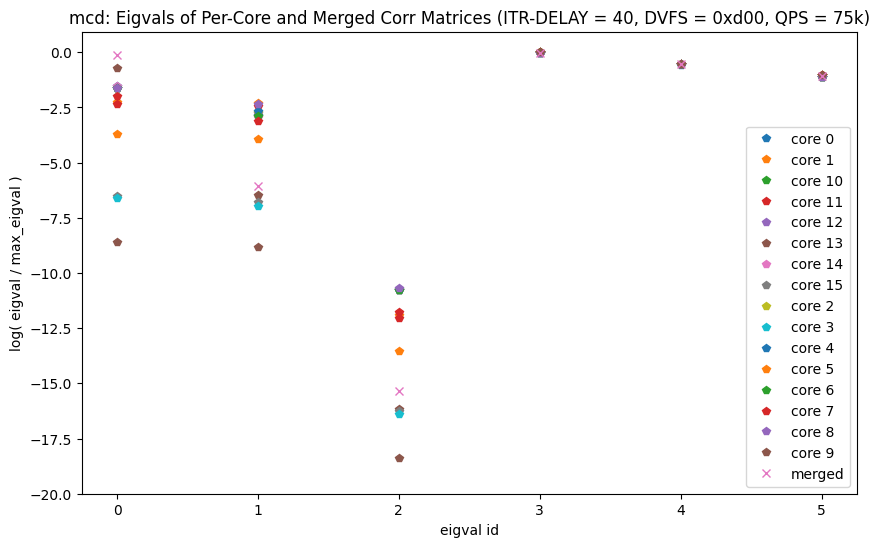


ITR-DELAY = 10,   DVFS = 0xd00,    QPS = 75k


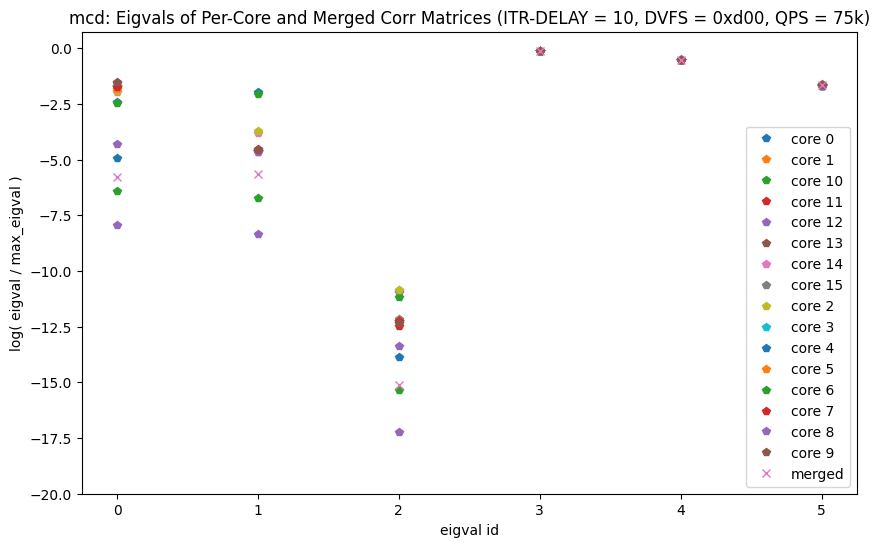


ITR-DELAY = 50,   DVFS = 0xd00,    QPS = 75k


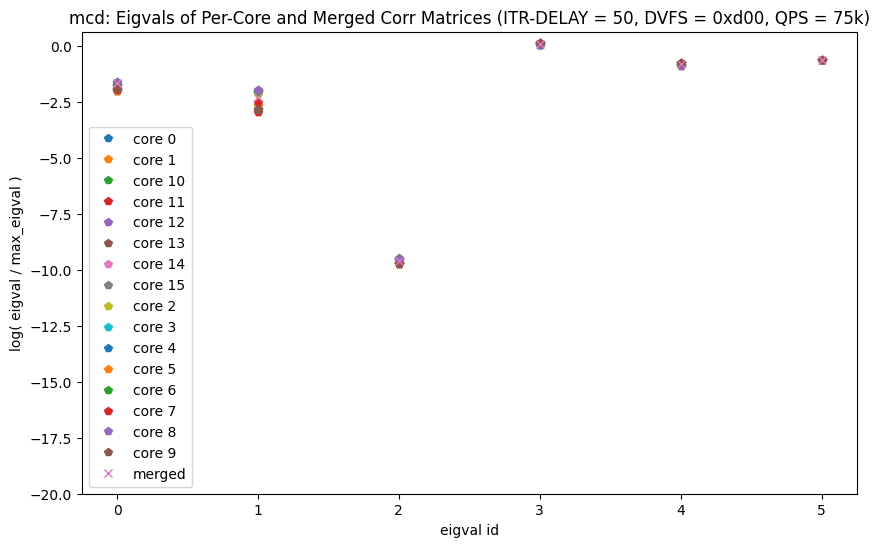


ITR-DELAY = 20,   DVFS = 0xd00,    QPS = 75k


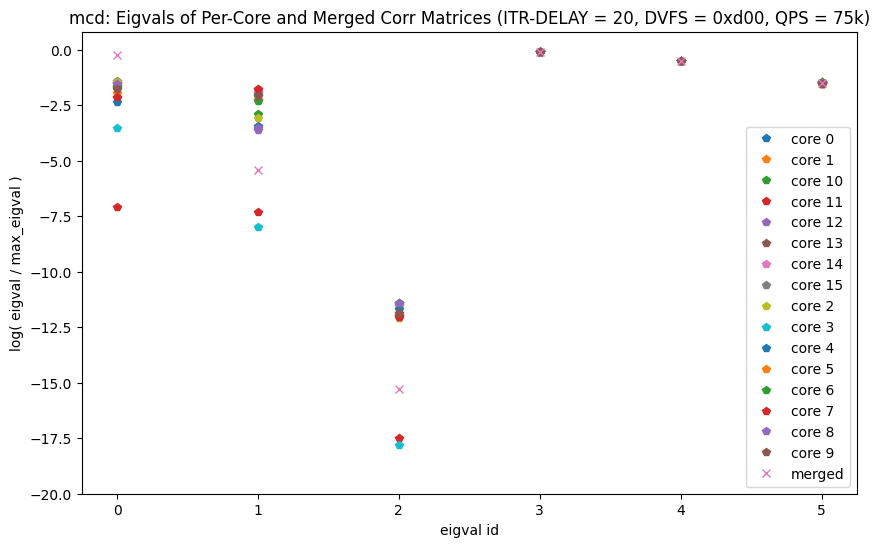


ITR-DELAY = 200,   DVFS = 0xd00,    QPS = 75k


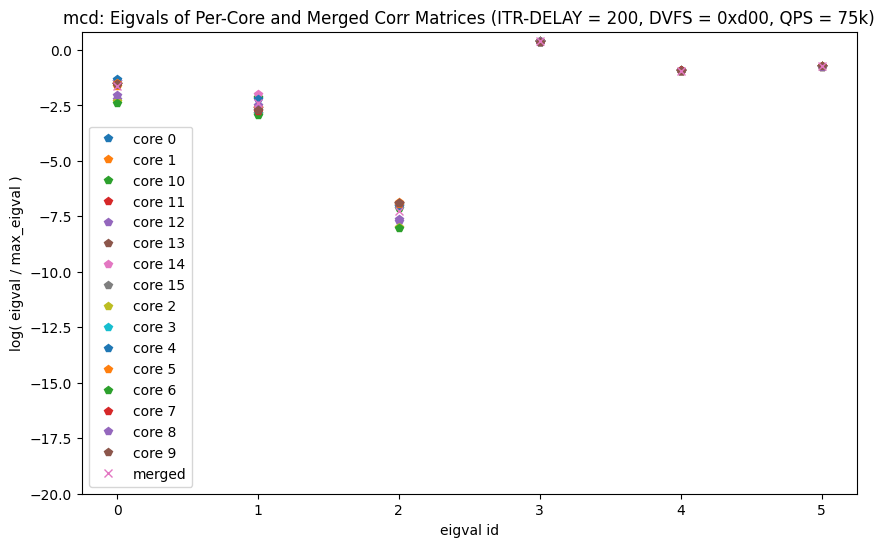


ITR-DELAY = 100,   DVFS = 0xd00,    QPS = 75k


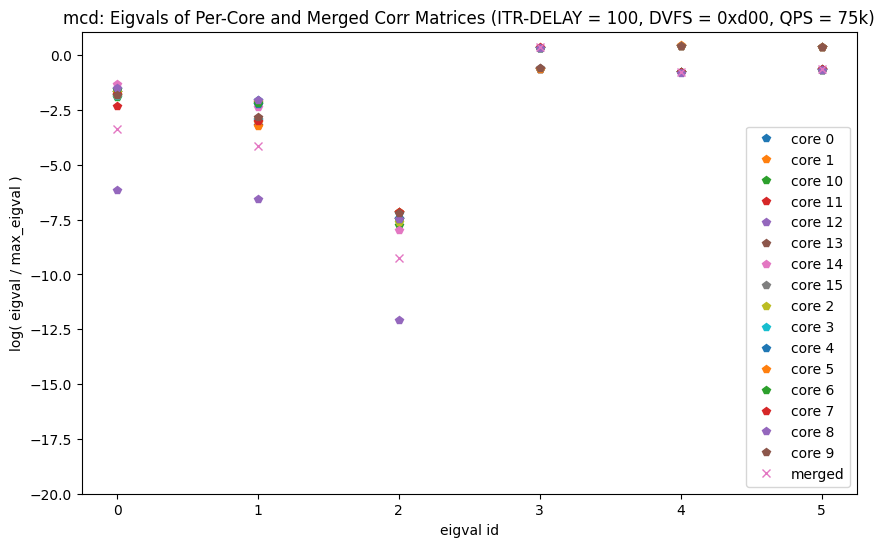


ITR-DELAY = 300,   DVFS = 0xf00,    QPS = 75k


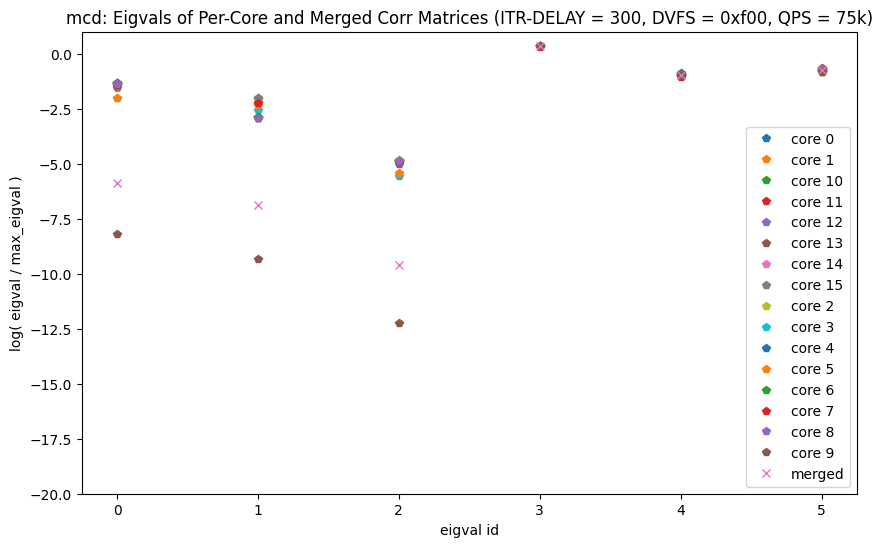


ITR-DELAY = 30,   DVFS = 0xf00,    QPS = 75k


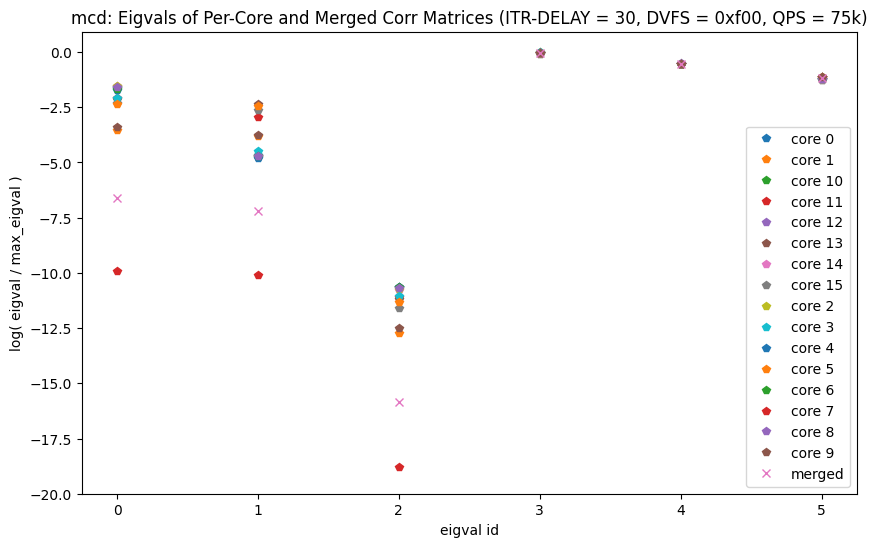


ITR-DELAY = 2,   DVFS = 0xf00,    QPS = 75k


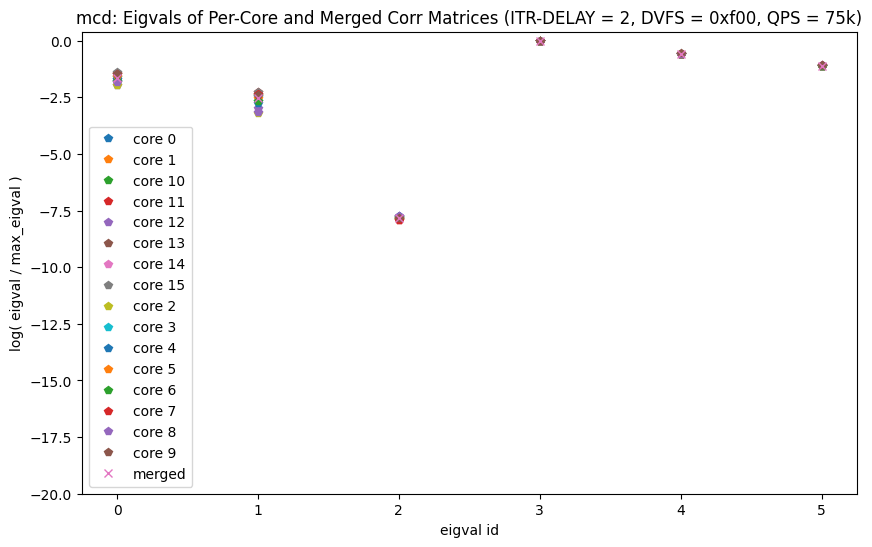


ITR-DELAY = 400,   DVFS = 0xf00,    QPS = 75k


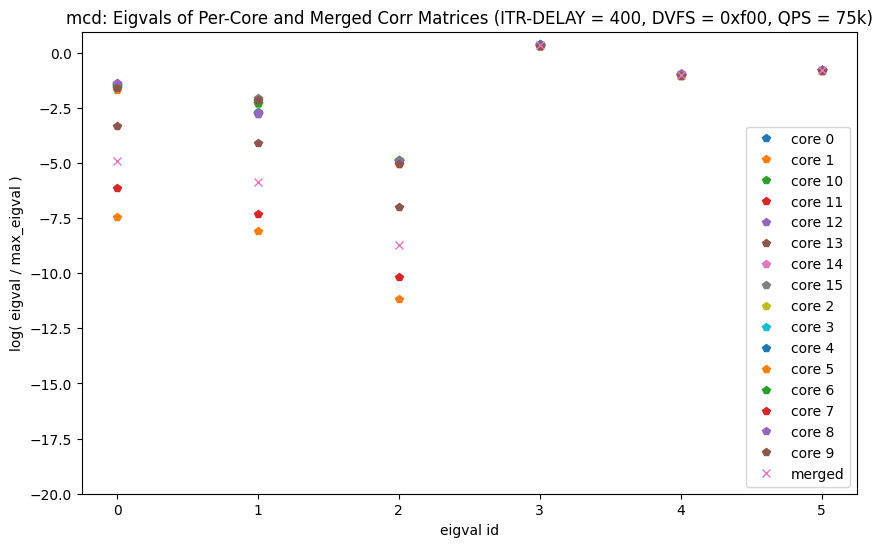


ITR-DELAY = 4,   DVFS = 0xf00,    QPS = 75k


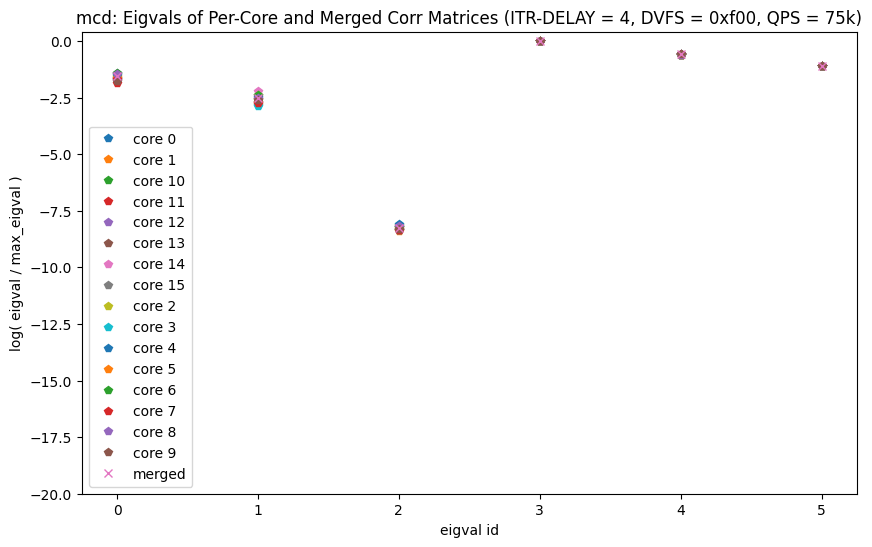


ITR-DELAY = 40,   DVFS = 0xf00,    QPS = 75k


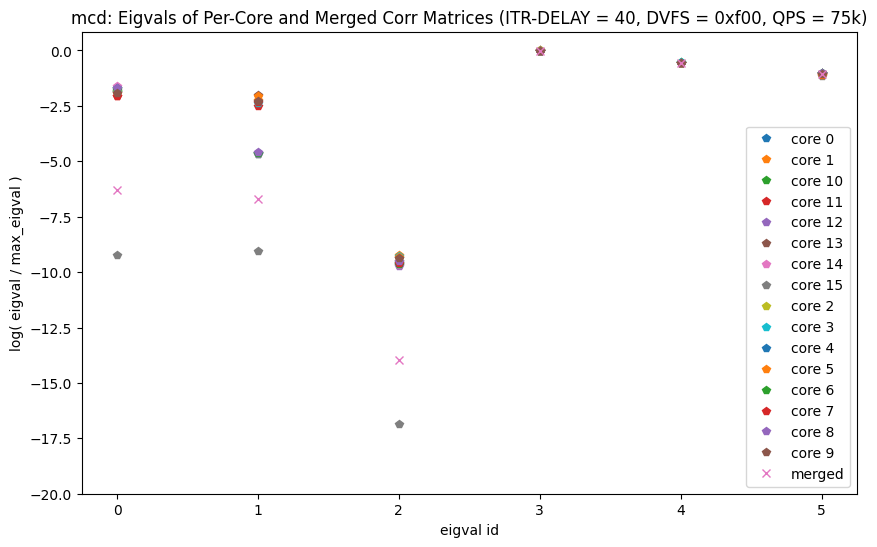


ITR-DELAY = 10,   DVFS = 0xf00,    QPS = 75k


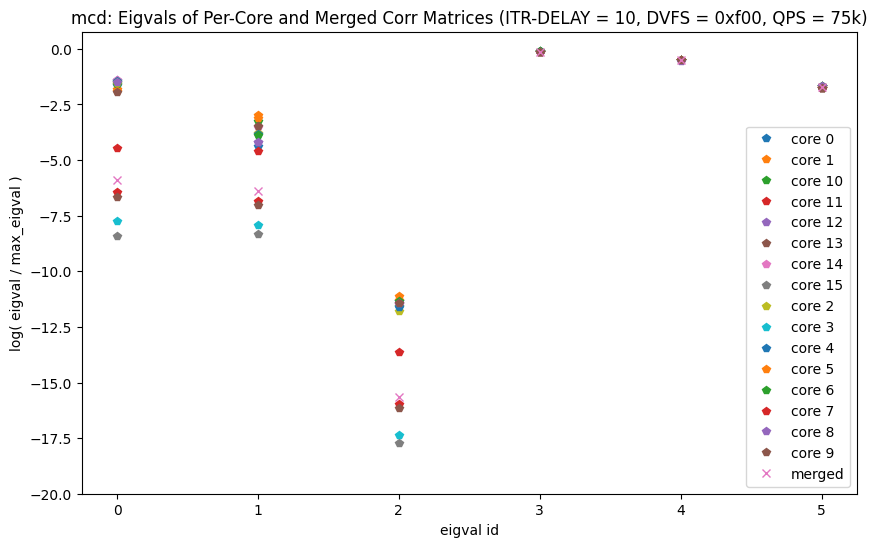


ITR-DELAY = 50,   DVFS = 0xf00,    QPS = 75k


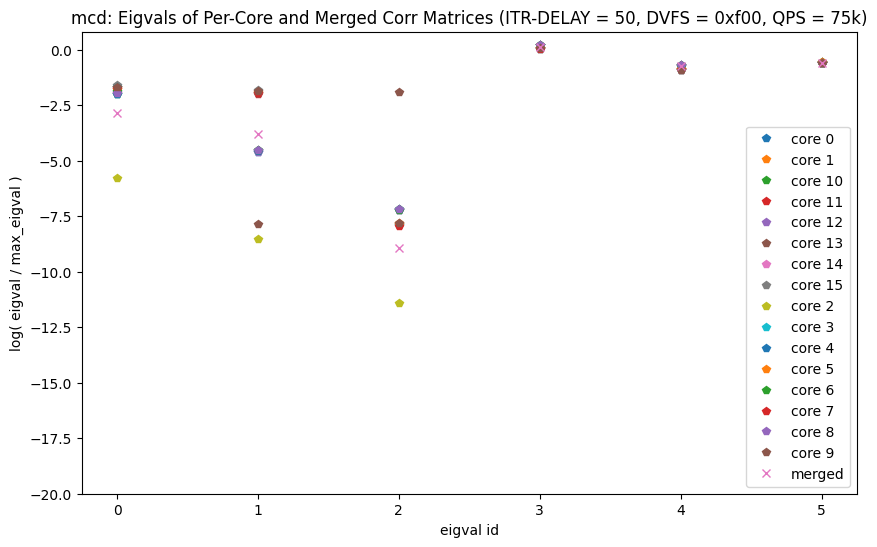


ITR-DELAY = 20,   DVFS = 0xf00,    QPS = 75k


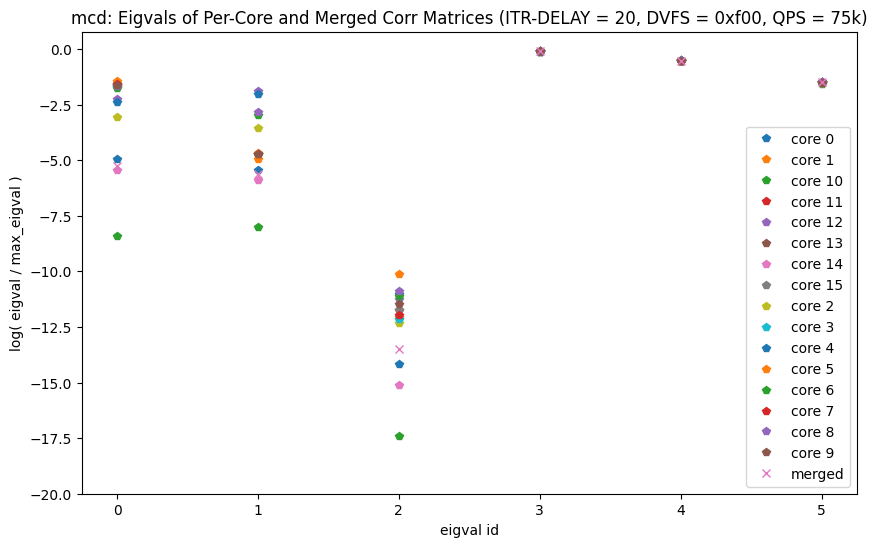


ITR-DELAY = 200,   DVFS = 0xf00,    QPS = 75k


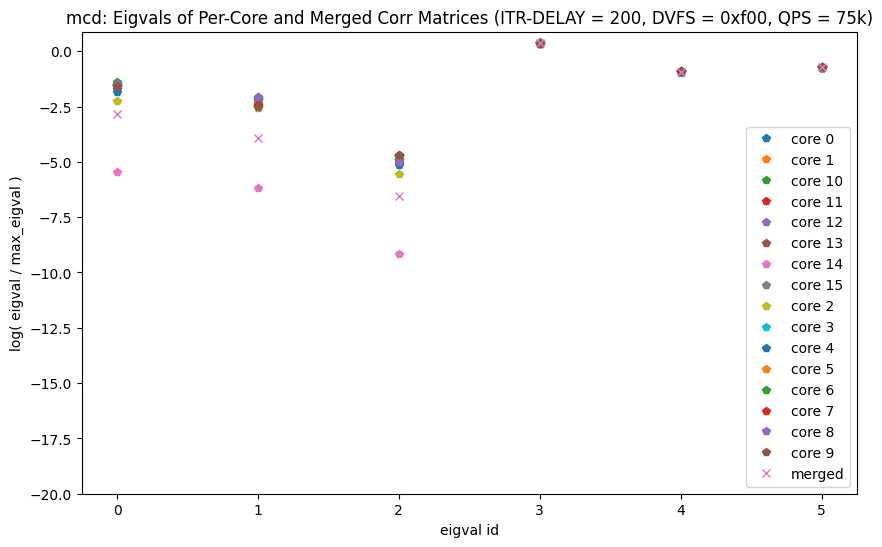


ITR-DELAY = 100,   DVFS = 0xf00,    QPS = 75k


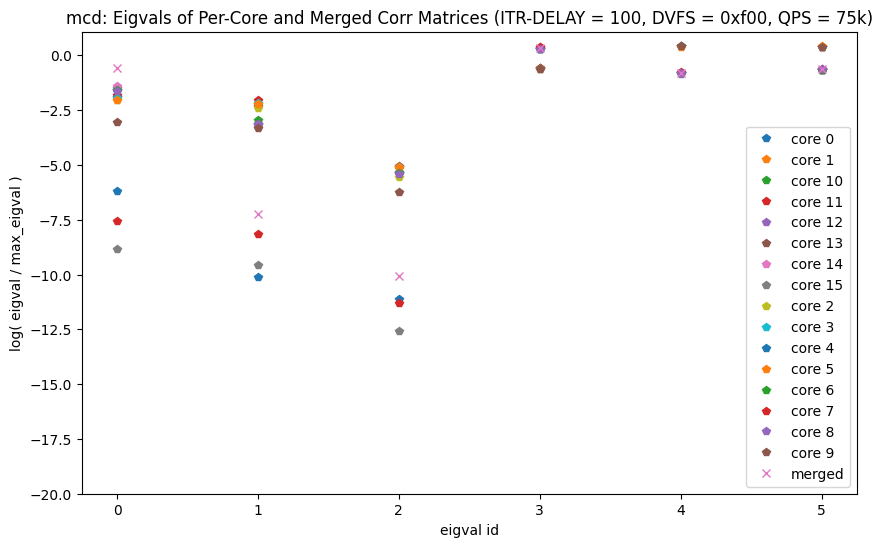


ITR-DELAY = 300,   DVFS = 0x1100,    QPS = 75k


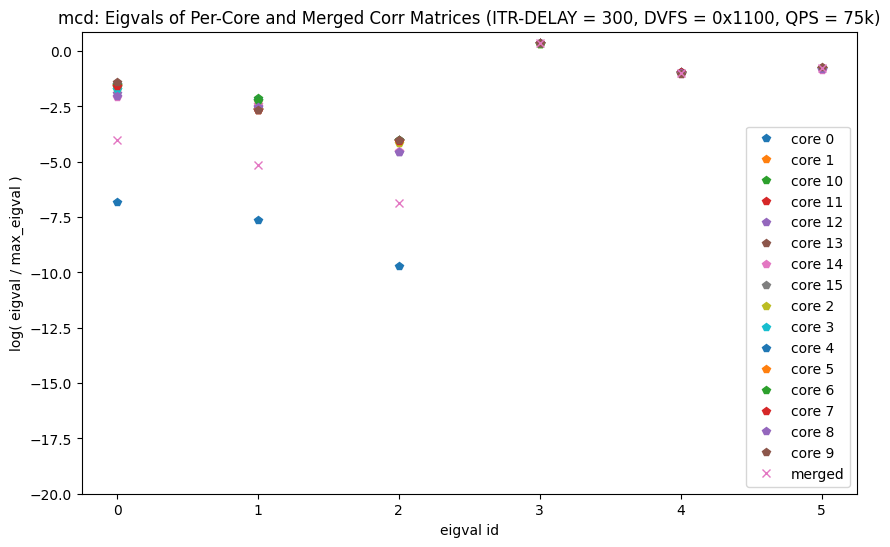


ITR-DELAY = 30,   DVFS = 0x1100,    QPS = 75k


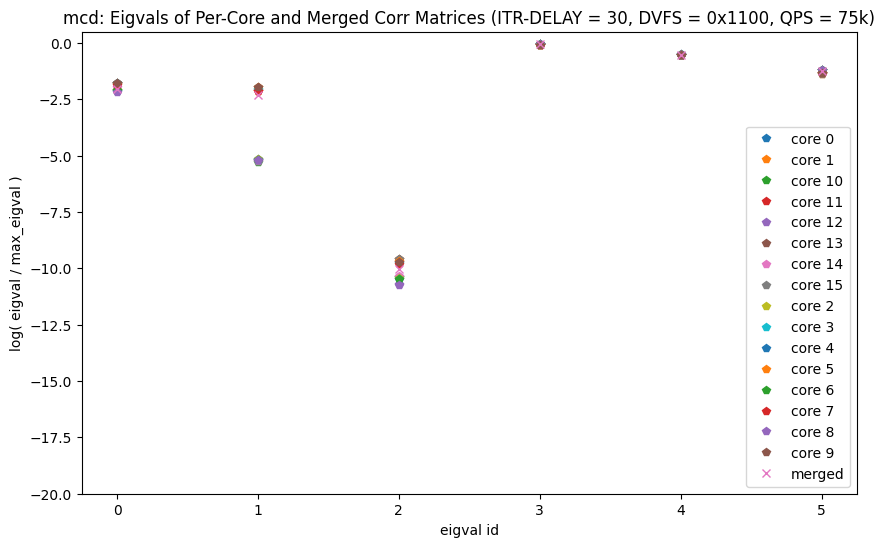


ITR-DELAY = 2,   DVFS = 0x1100,    QPS = 75k


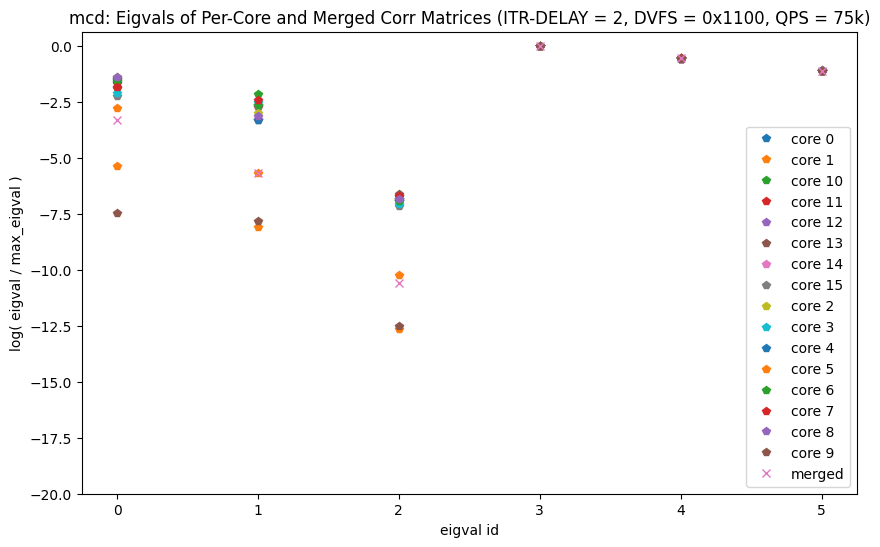


ITR-DELAY = 400,   DVFS = 0x1100,    QPS = 75k


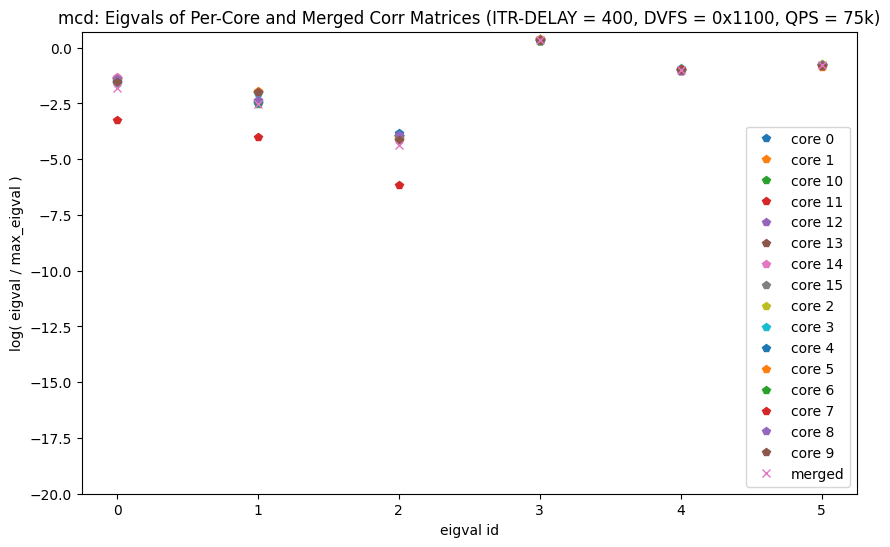


ITR-DELAY = 4,   DVFS = 0x1100,    QPS = 75k


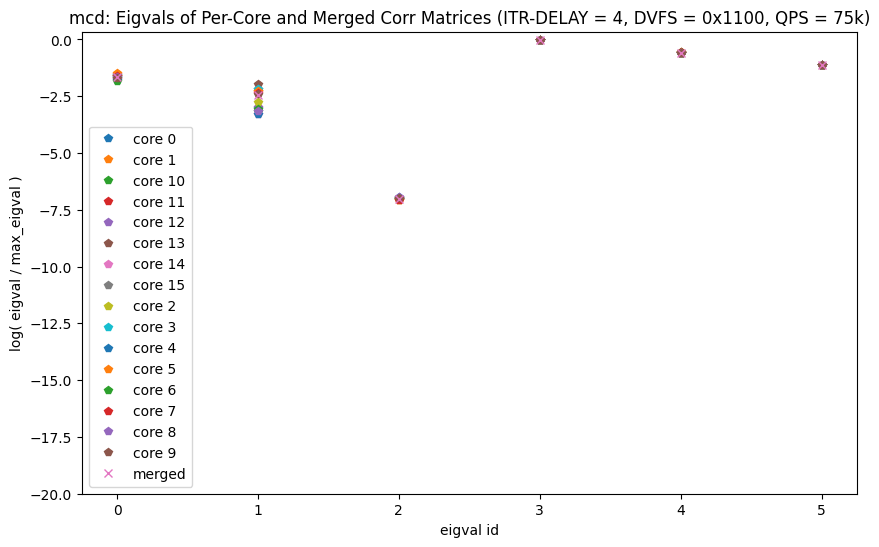


ITR-DELAY = 40,   DVFS = 0x1100,    QPS = 75k


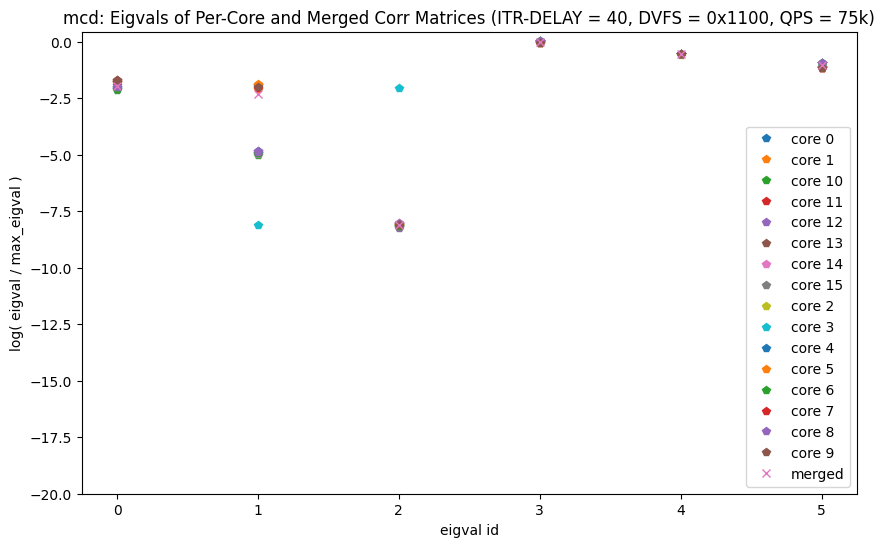


ITR-DELAY = 10,   DVFS = 0x1100,    QPS = 75k


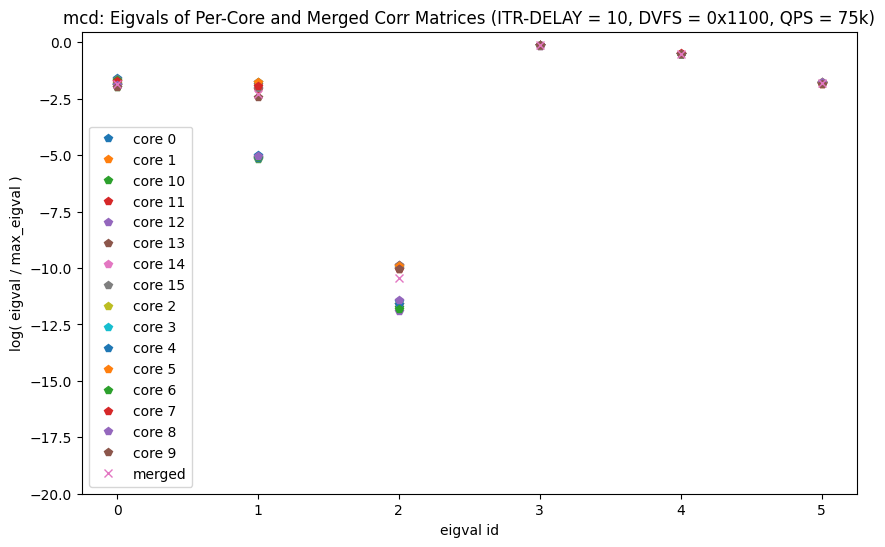


ITR-DELAY = 50,   DVFS = 0x1100,    QPS = 75k


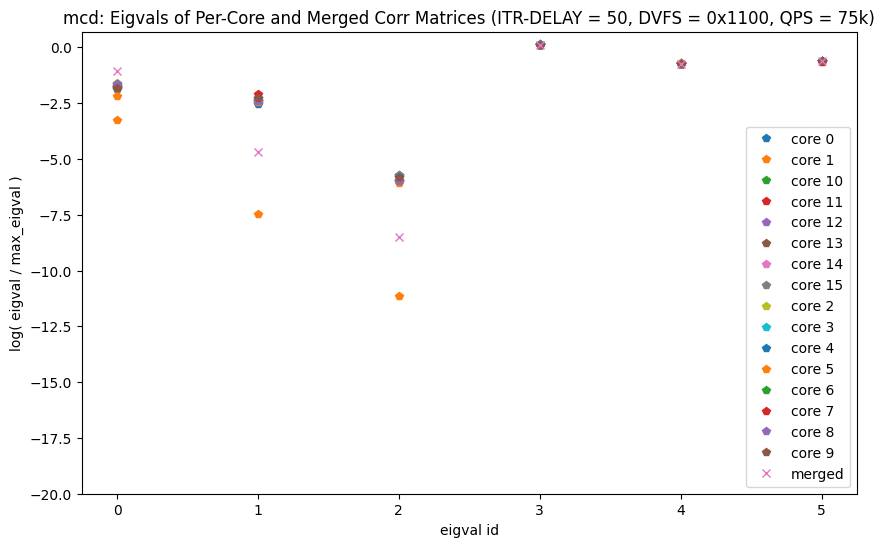


ITR-DELAY = 20,   DVFS = 0x1100,    QPS = 75k


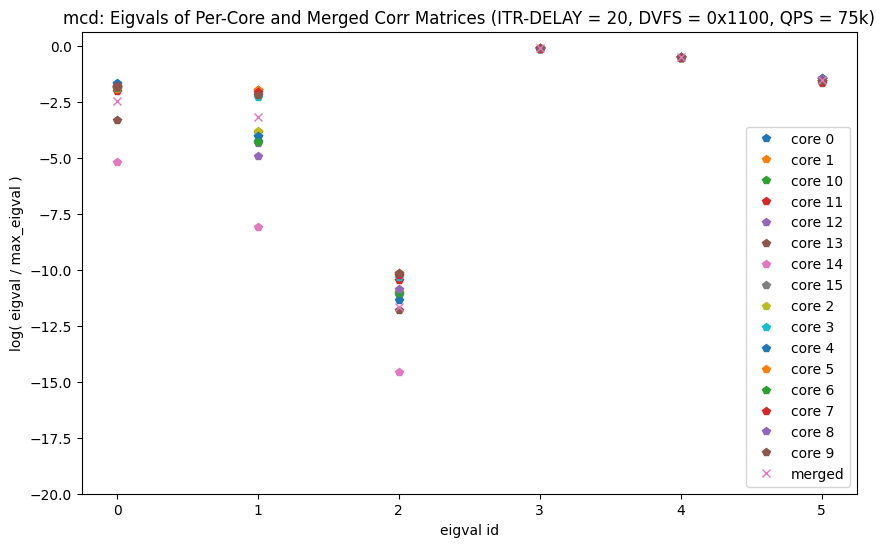


ITR-DELAY = 200,   DVFS = 0x1100,    QPS = 75k


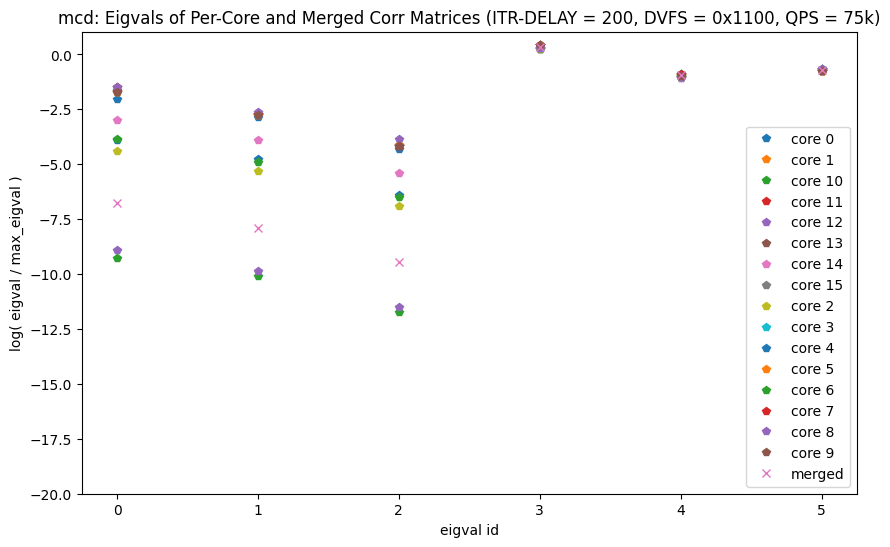


ITR-DELAY = 100,   DVFS = 0x1100,    QPS = 75k


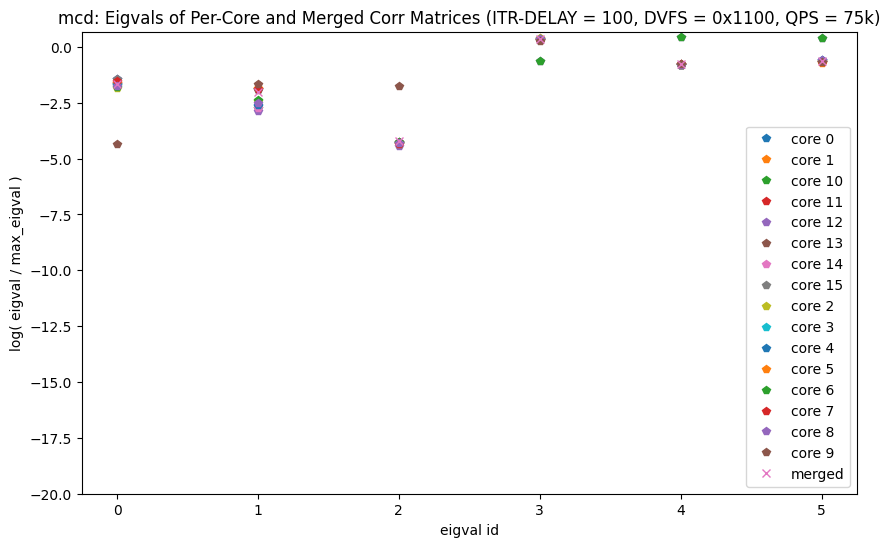


ITR-DELAY = 300,   DVFS = 0x1300,    QPS = 75k


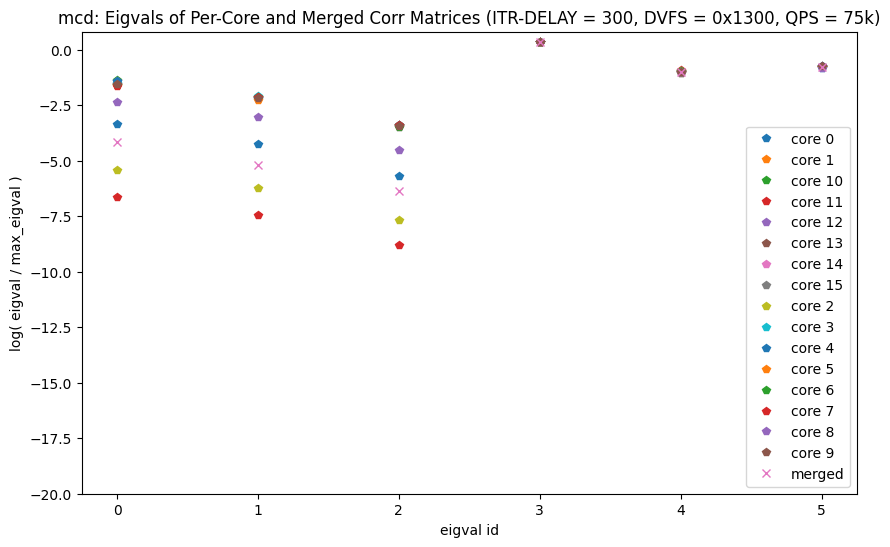


ITR-DELAY = 30,   DVFS = 0x1300,    QPS = 75k


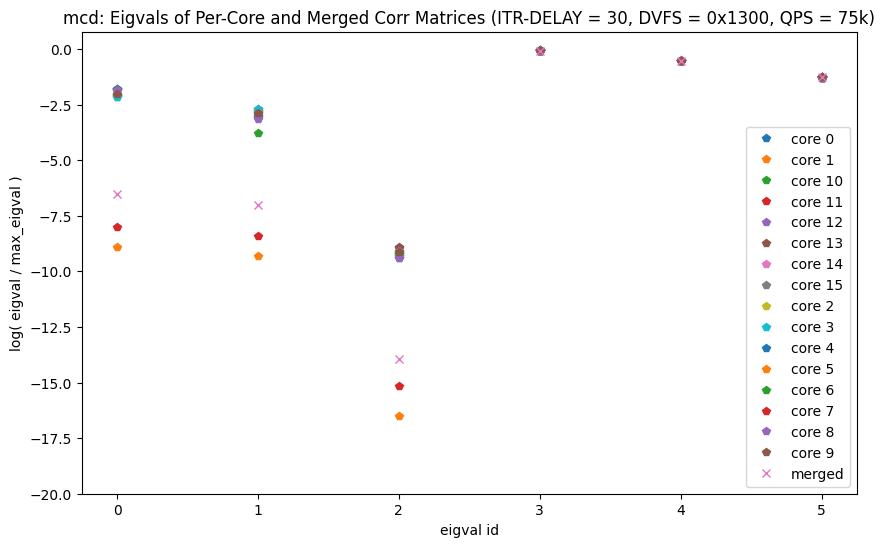


ITR-DELAY = 2,   DVFS = 0x1300,    QPS = 75k


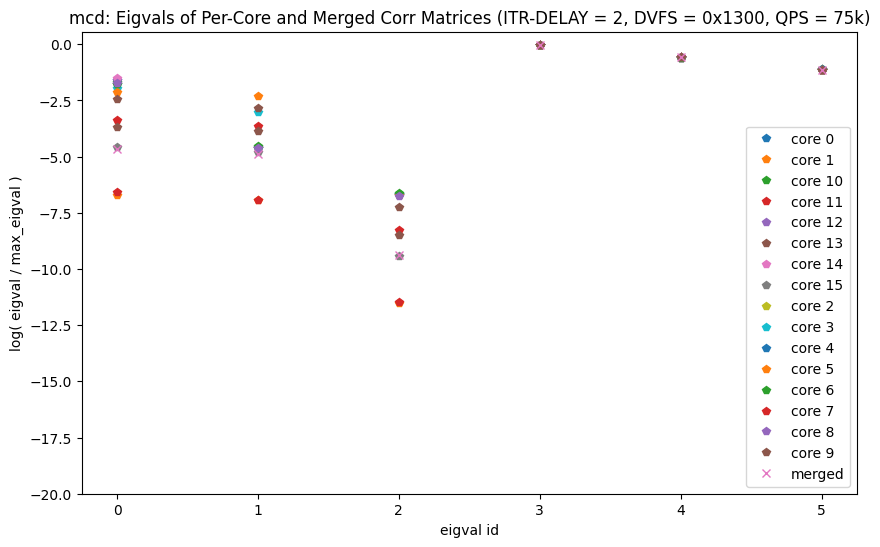


ITR-DELAY = 400,   DVFS = 0x1300,    QPS = 75k


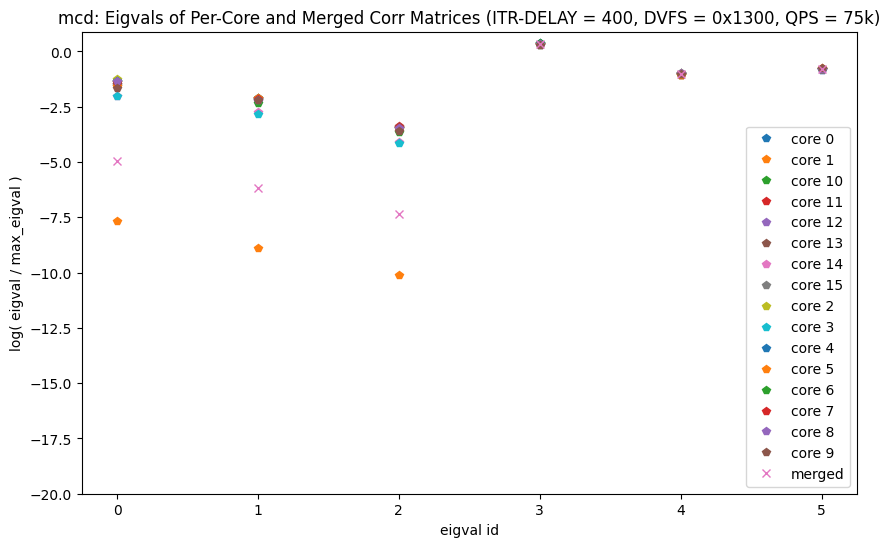


ITR-DELAY = 4,   DVFS = 0x1300,    QPS = 75k


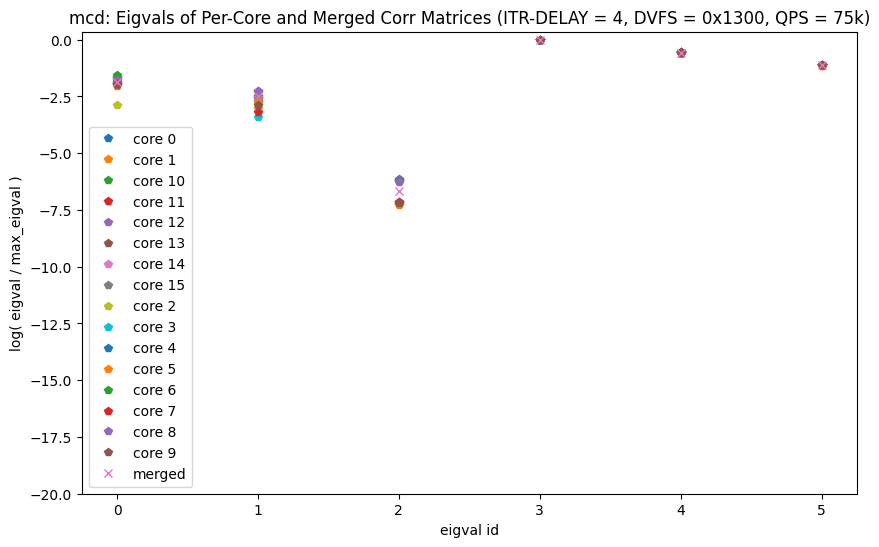


ITR-DELAY = 40,   DVFS = 0x1300,    QPS = 75k


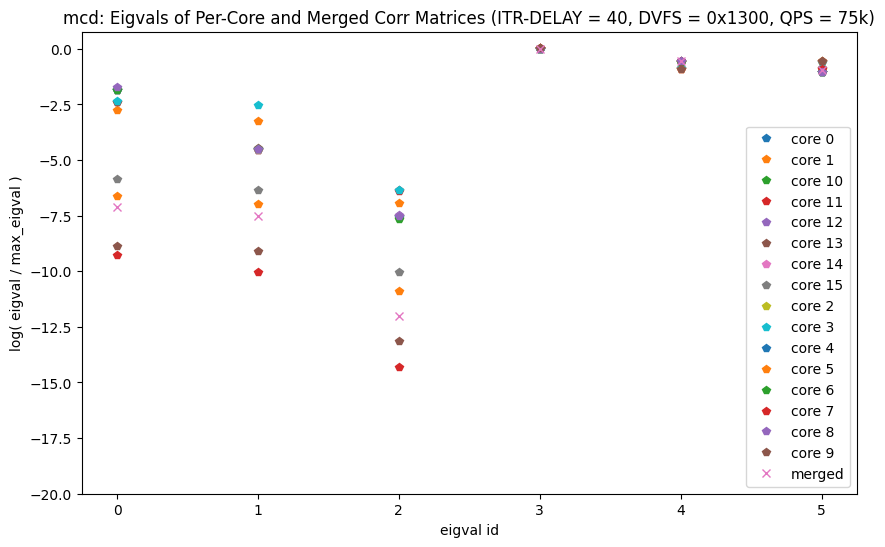


ITR-DELAY = 10,   DVFS = 0x1300,    QPS = 75k


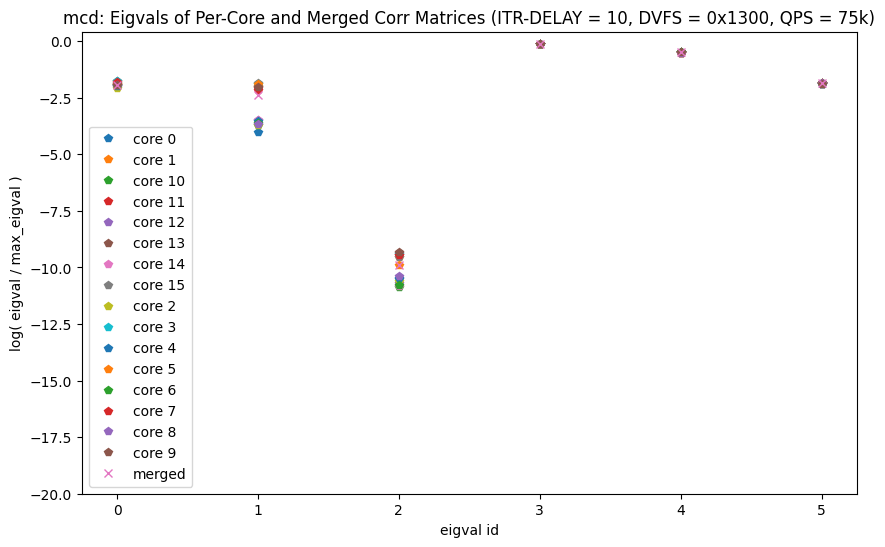


ITR-DELAY = 50,   DVFS = 0x1300,    QPS = 75k


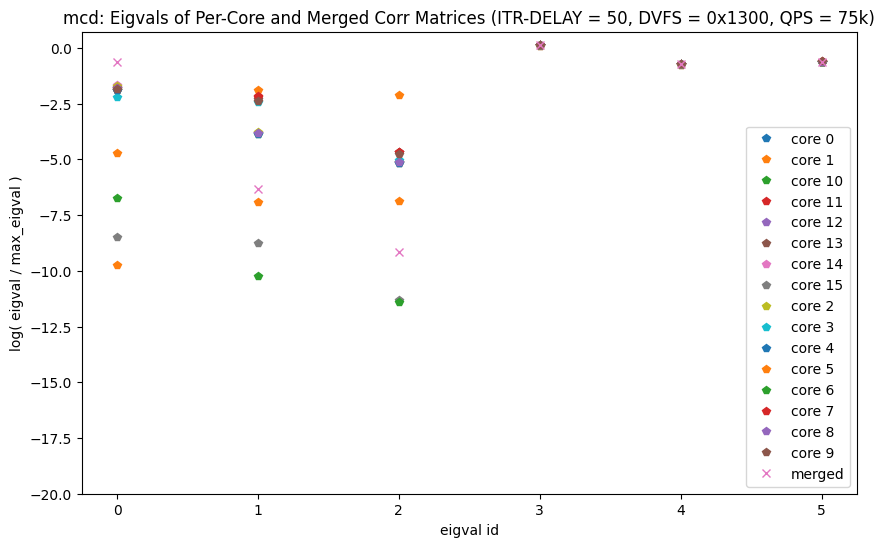


ITR-DELAY = 20,   DVFS = 0x1300,    QPS = 75k


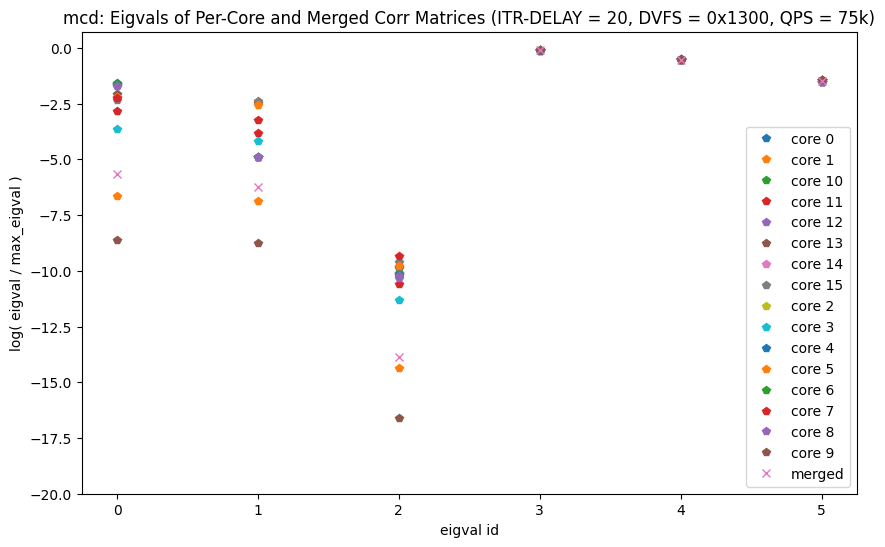


ITR-DELAY = 200,   DVFS = 0x1300,    QPS = 75k


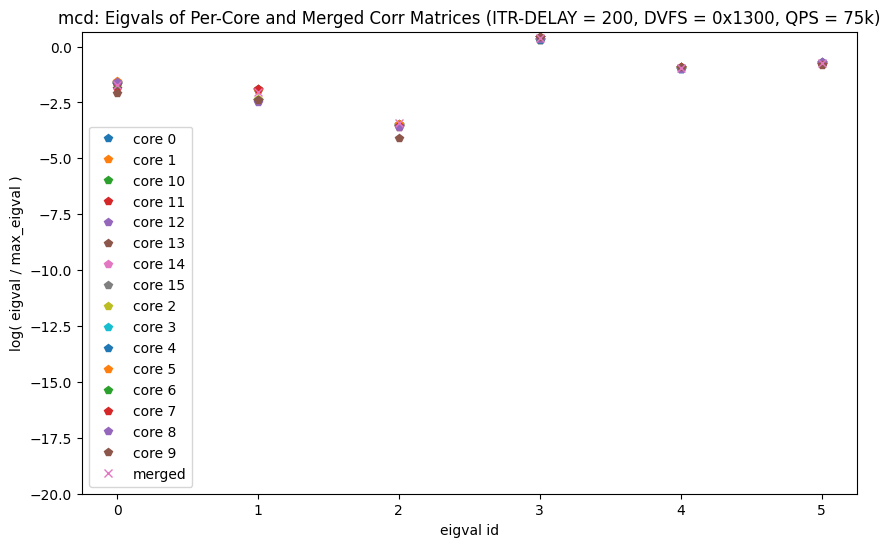


ITR-DELAY = 100,   DVFS = 0x1300,    QPS = 75k


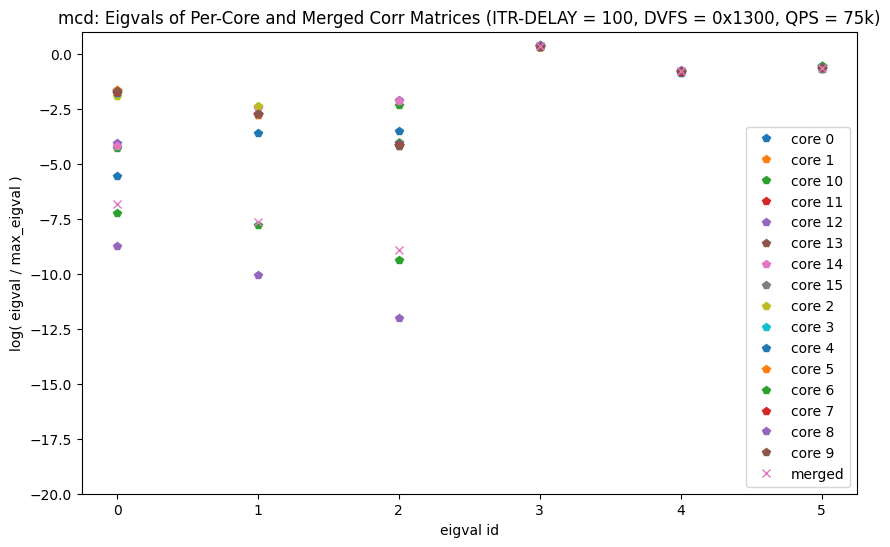


ITR-DELAY = 300,   DVFS = 0x1500,    QPS = 75k


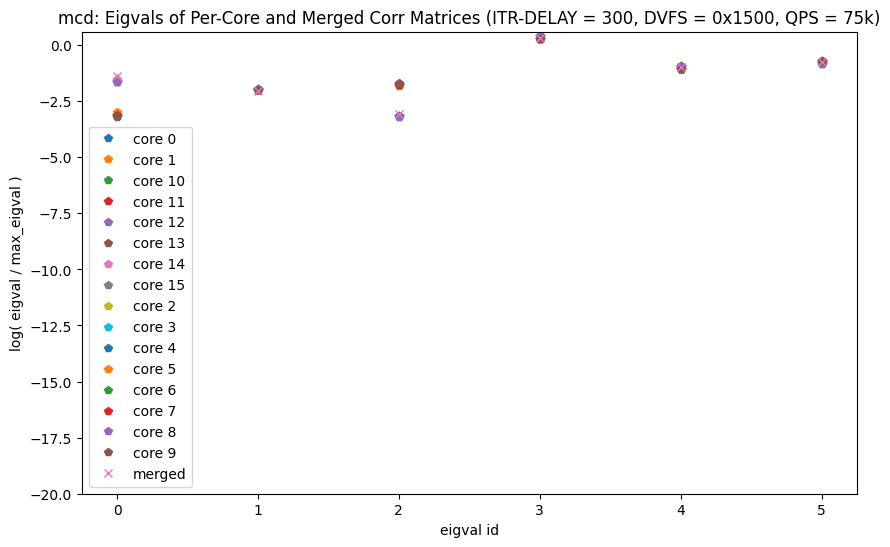


ITR-DELAY = 30,   DVFS = 0x1500,    QPS = 75k


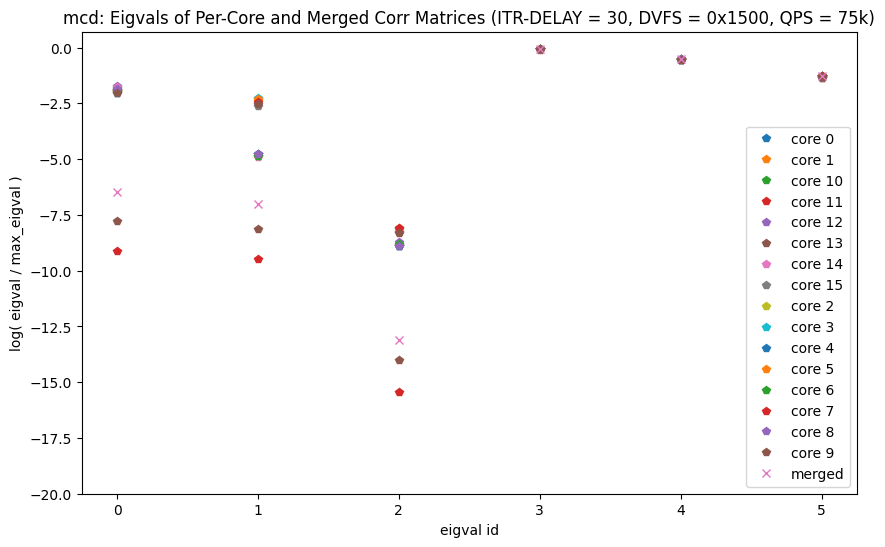


ITR-DELAY = 2,   DVFS = 0x1500,    QPS = 75k


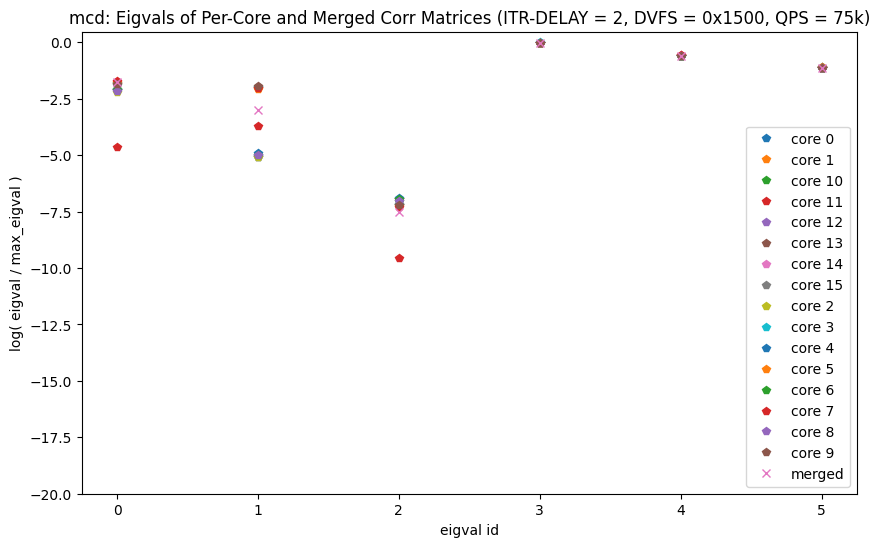


ITR-DELAY = 400,   DVFS = 0x1500,    QPS = 75k


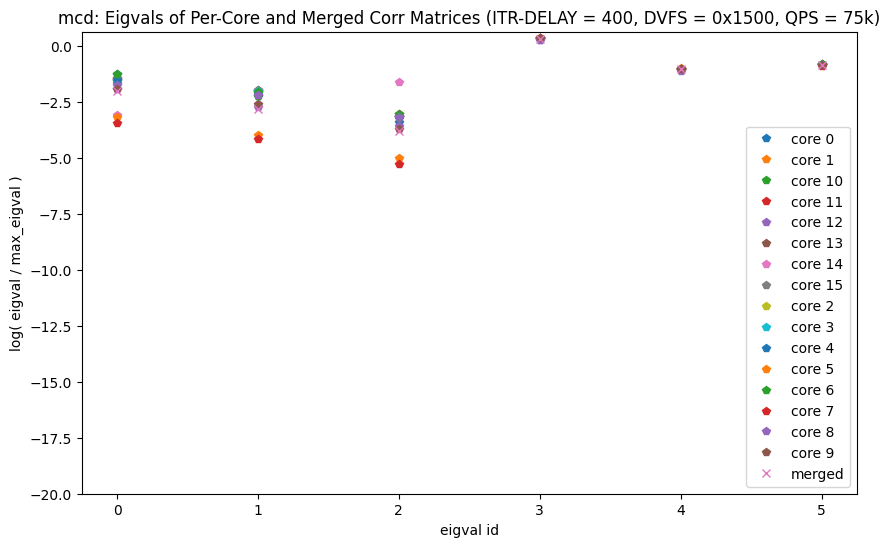


ITR-DELAY = 4,   DVFS = 0x1500,    QPS = 75k


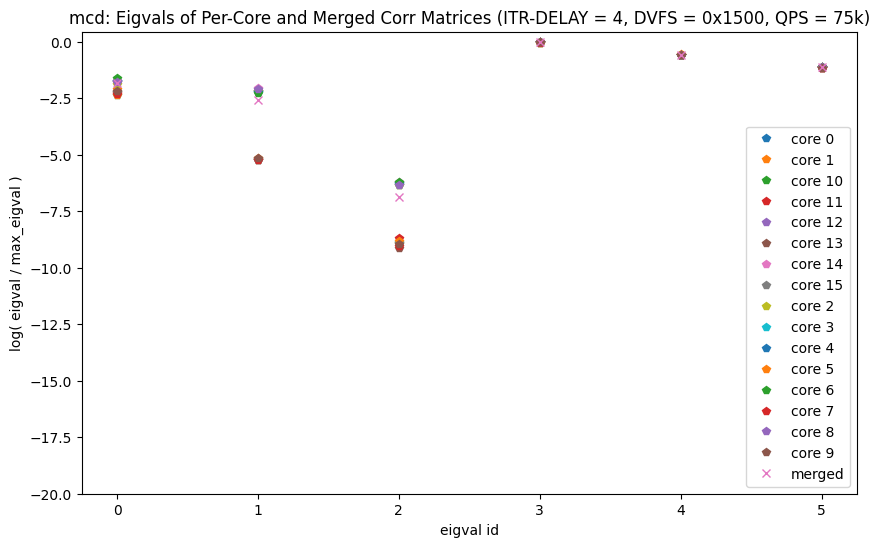


ITR-DELAY = 40,   DVFS = 0x1500,    QPS = 75k


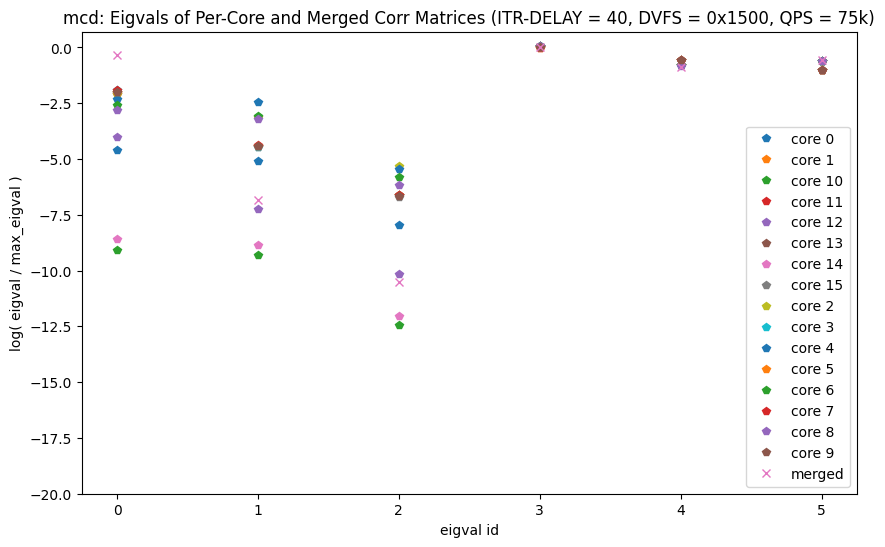


ITR-DELAY = 10,   DVFS = 0x1500,    QPS = 75k


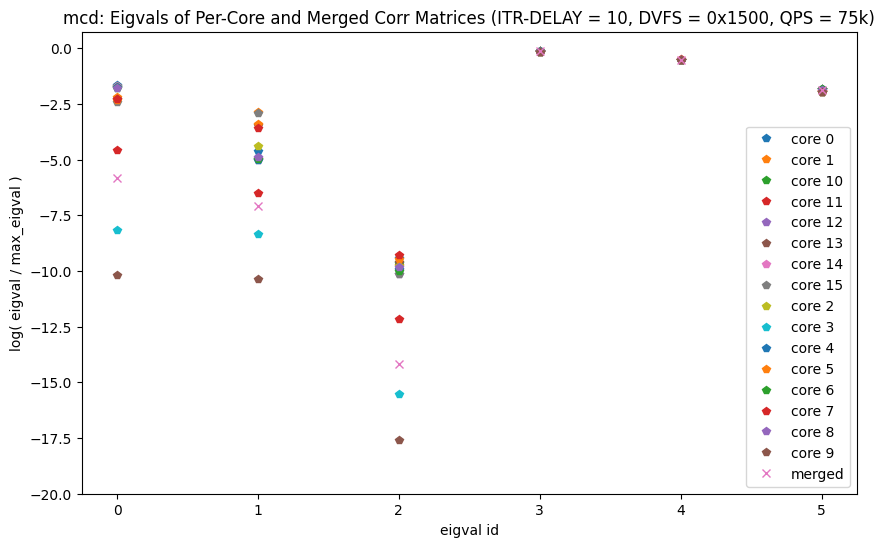


ITR-DELAY = 50,   DVFS = 0x1500,    QPS = 75k


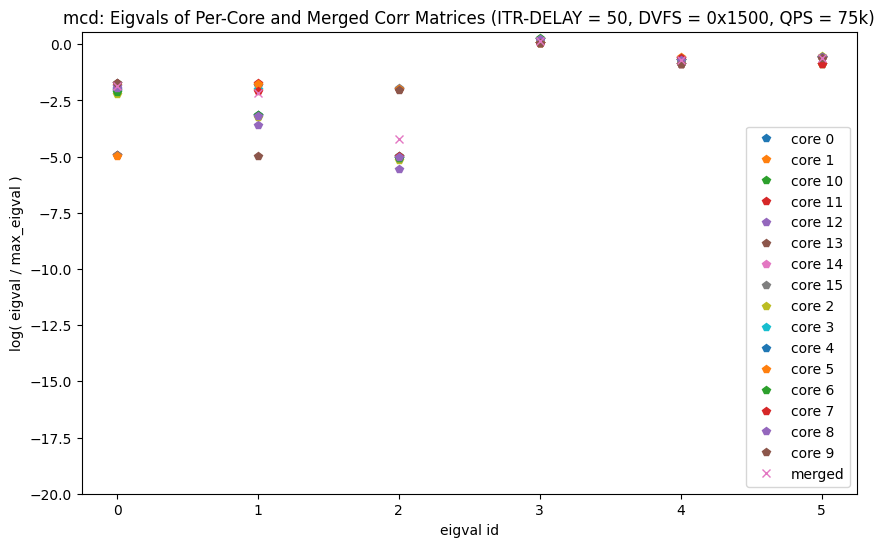


ITR-DELAY = 20,   DVFS = 0x1500,    QPS = 75k


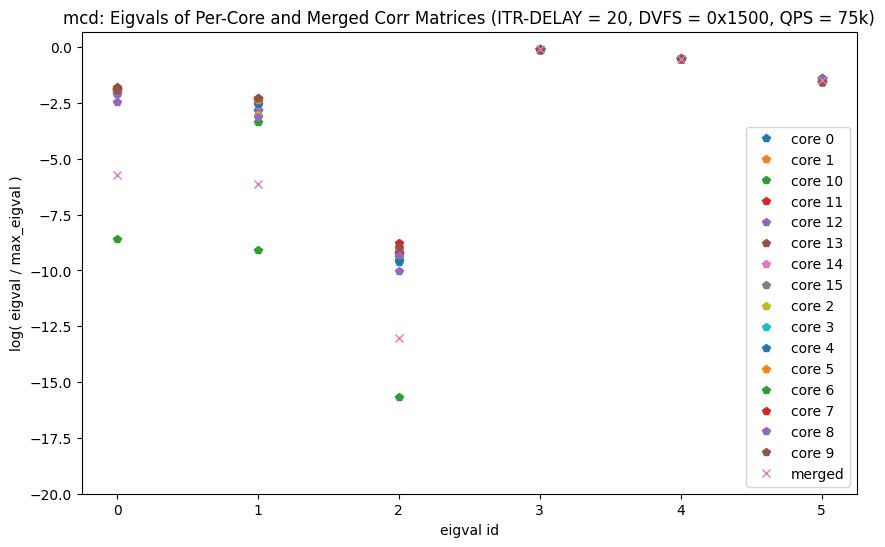


ITR-DELAY = 200,   DVFS = 0x1500,    QPS = 75k


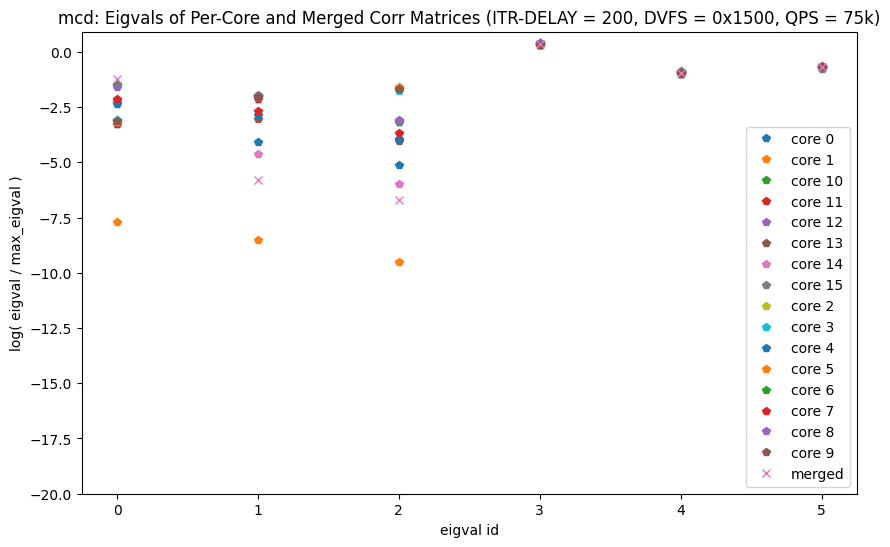


ITR-DELAY = 100,   DVFS = 0x1500,    QPS = 75k


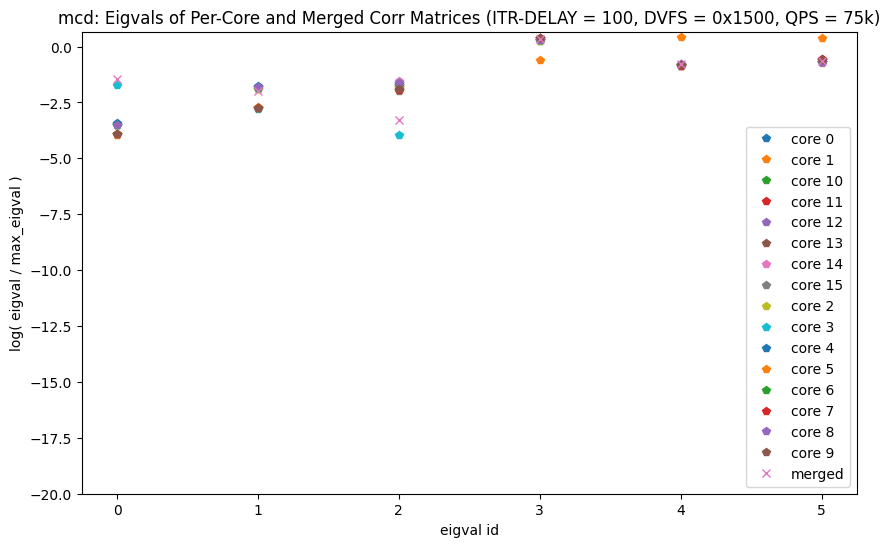


ITR-DELAY = 300,   DVFS = 0x1700,    QPS = 75k

ITR-DELAY = 30,   DVFS = 0x1700,    QPS = 75k

ITR-DELAY = 2,   DVFS = 0x1700,    QPS = 75k


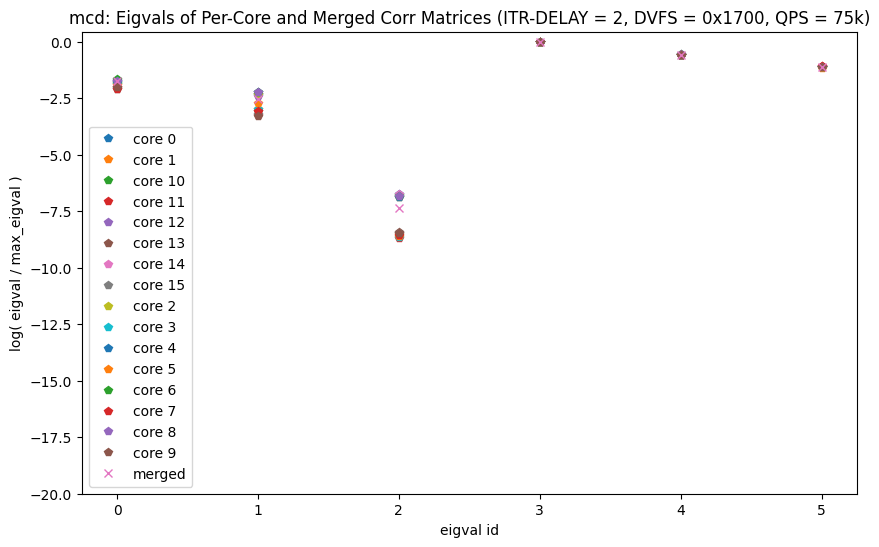


ITR-DELAY = 400,   DVFS = 0x1700,    QPS = 75k

ITR-DELAY = 4,   DVFS = 0x1700,    QPS = 75k


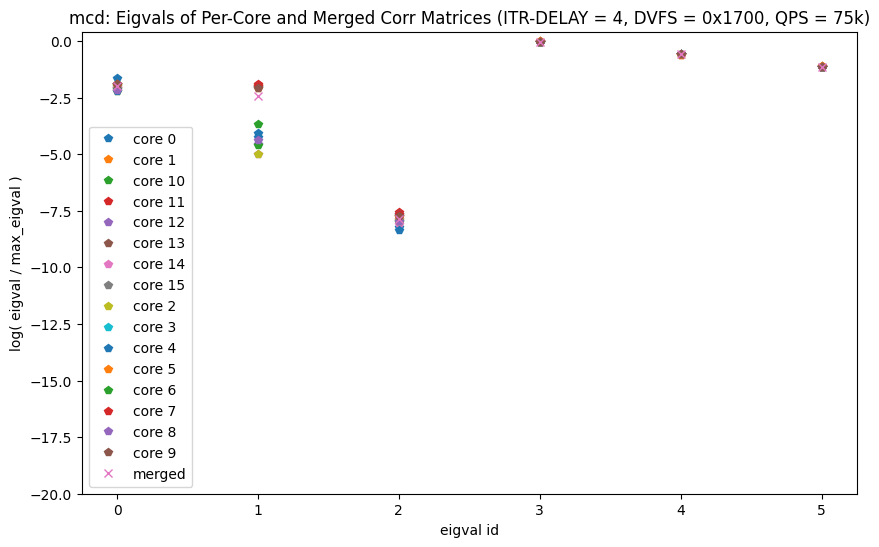


ITR-DELAY = 40,   DVFS = 0x1700,    QPS = 75k

ITR-DELAY = 10,   DVFS = 0x1700,    QPS = 75k

ITR-DELAY = 50,   DVFS = 0x1700,    QPS = 75k

ITR-DELAY = 20,   DVFS = 0x1700,    QPS = 75k

ITR-DELAY = 200,   DVFS = 0x1700,    QPS = 75k

ITR-DELAY = 100,   DVFS = 0x1700,    QPS = 75k

ITR-DELAY = 300,   DVFS = 0x1900,    QPS = 75k


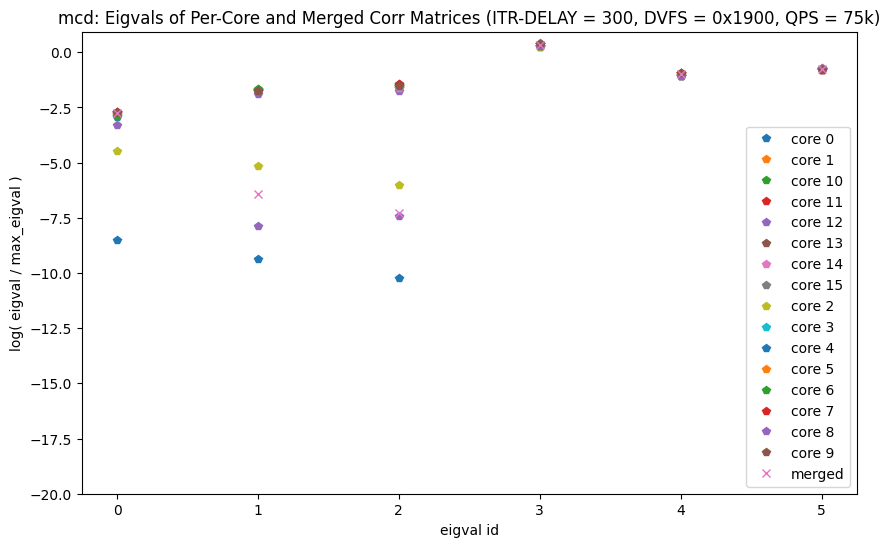


ITR-DELAY = 30,   DVFS = 0x1900,    QPS = 75k


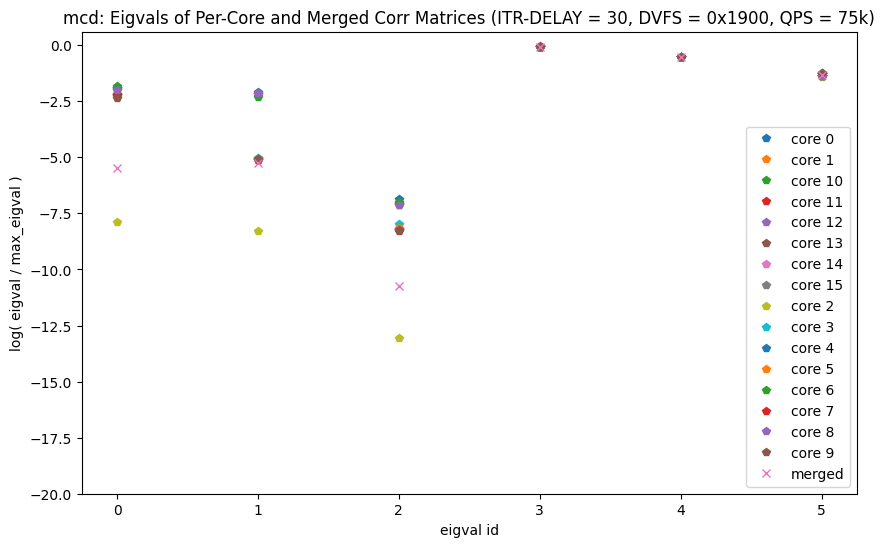


ITR-DELAY = 2,   DVFS = 0x1900,    QPS = 75k


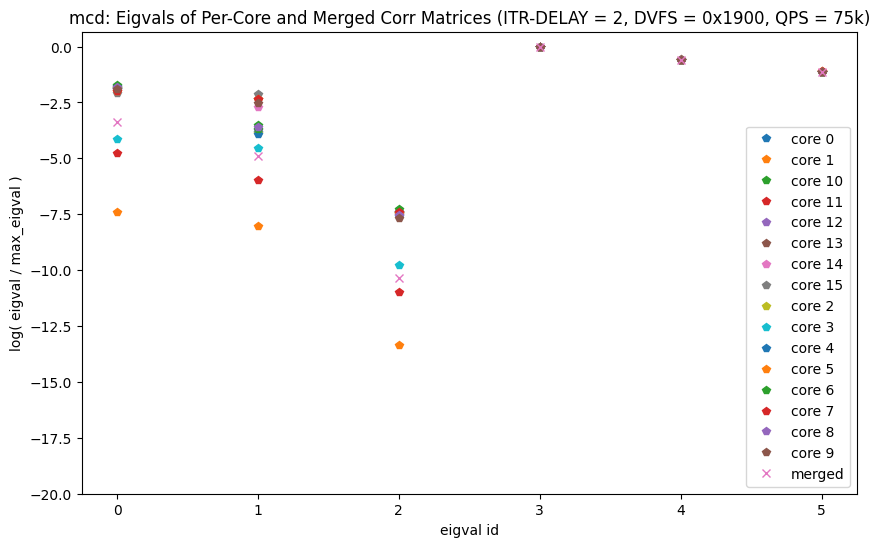


ITR-DELAY = 400,   DVFS = 0x1900,    QPS = 75k


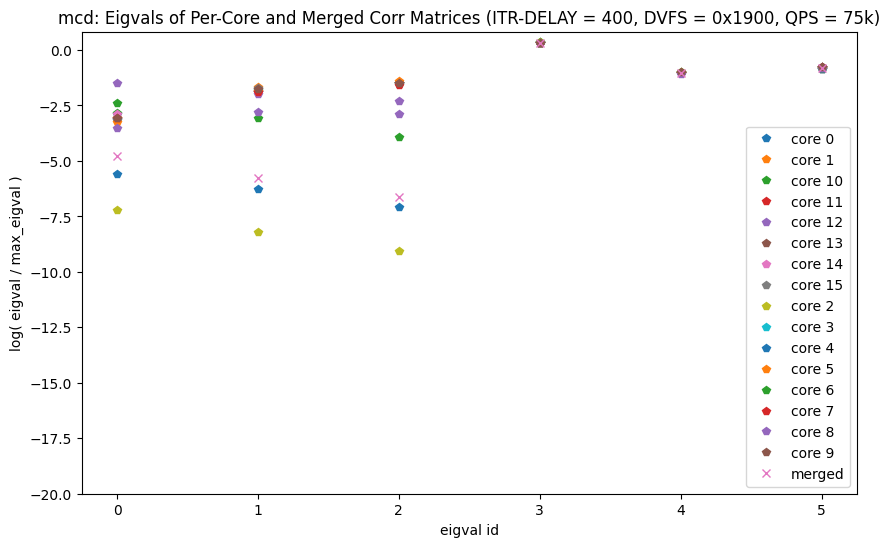


ITR-DELAY = 4,   DVFS = 0x1900,    QPS = 75k


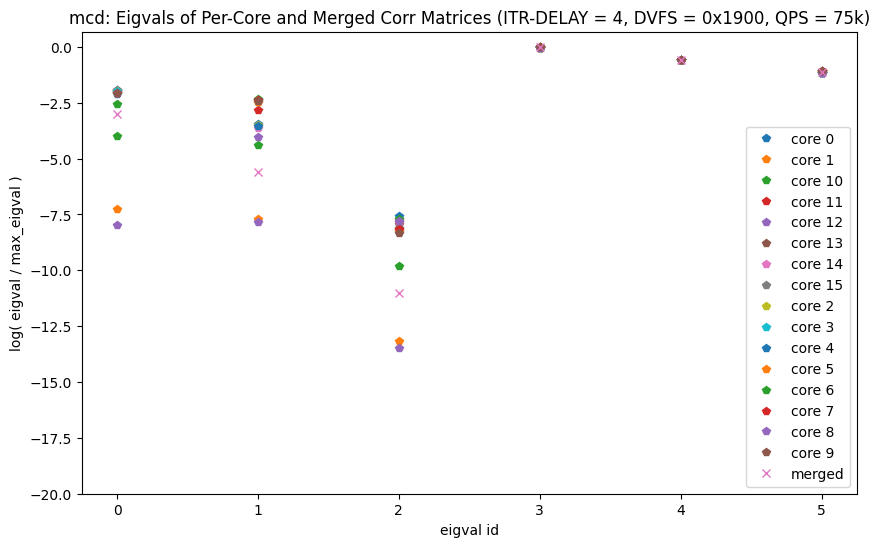


ITR-DELAY = 40,   DVFS = 0x1900,    QPS = 75k


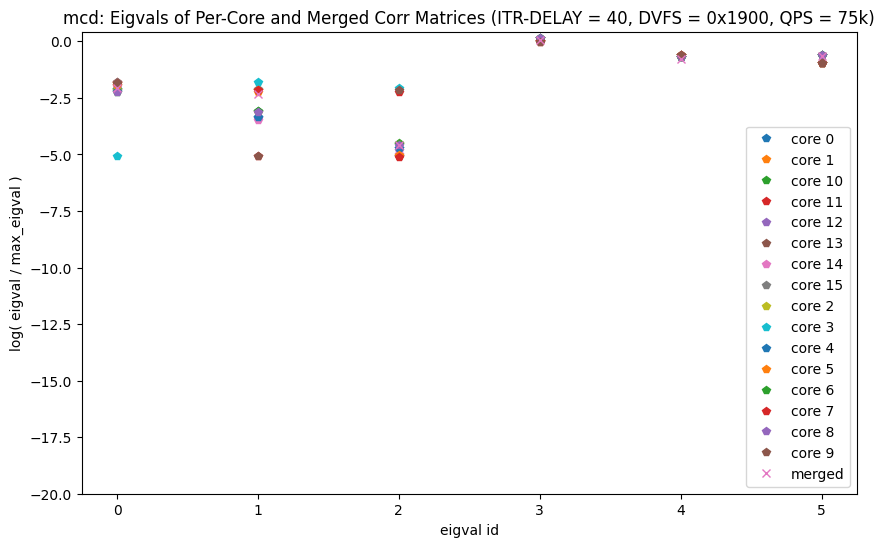


ITR-DELAY = 10,   DVFS = 0x1900,    QPS = 75k


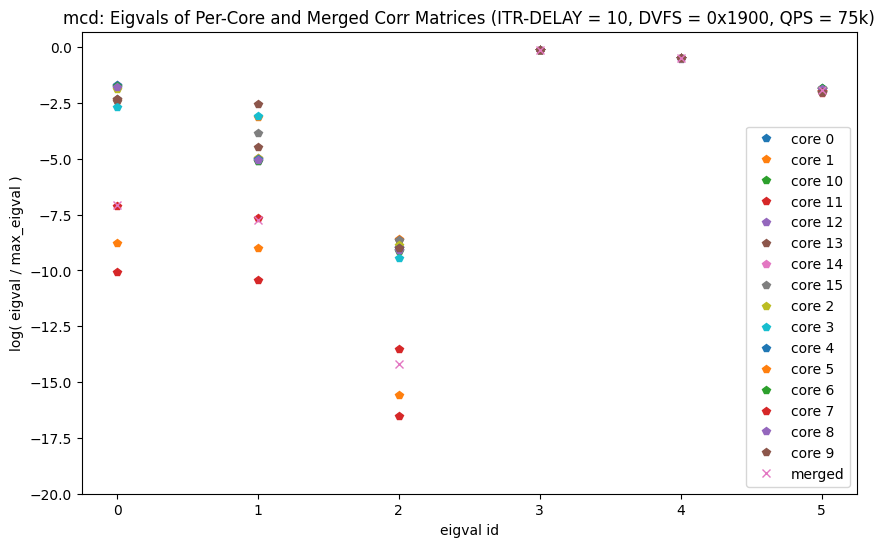


ITR-DELAY = 50,   DVFS = 0x1900,    QPS = 75k


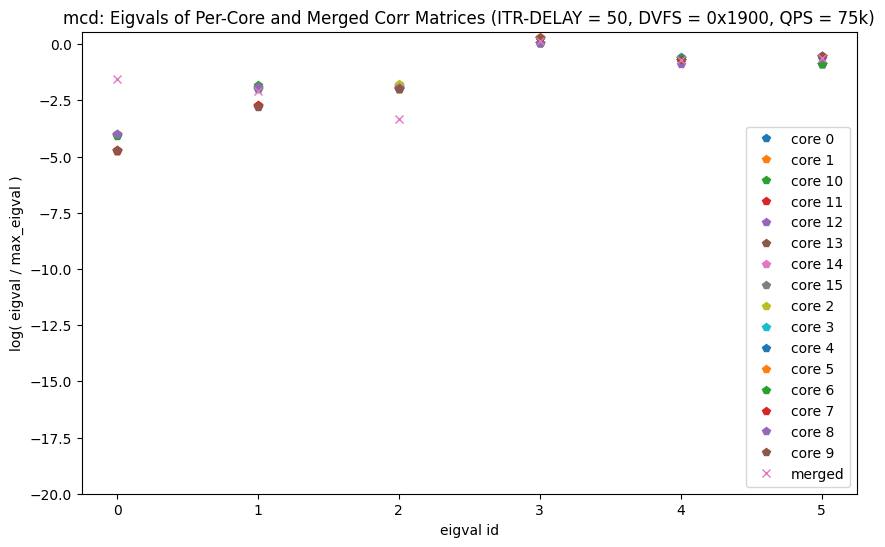


ITR-DELAY = 20,   DVFS = 0x1900,    QPS = 75k


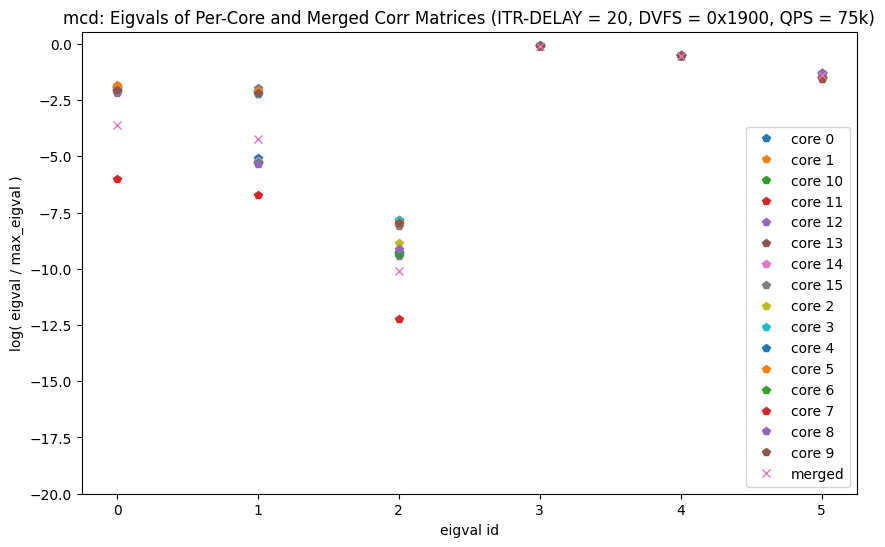


ITR-DELAY = 200,   DVFS = 0x1900,    QPS = 75k


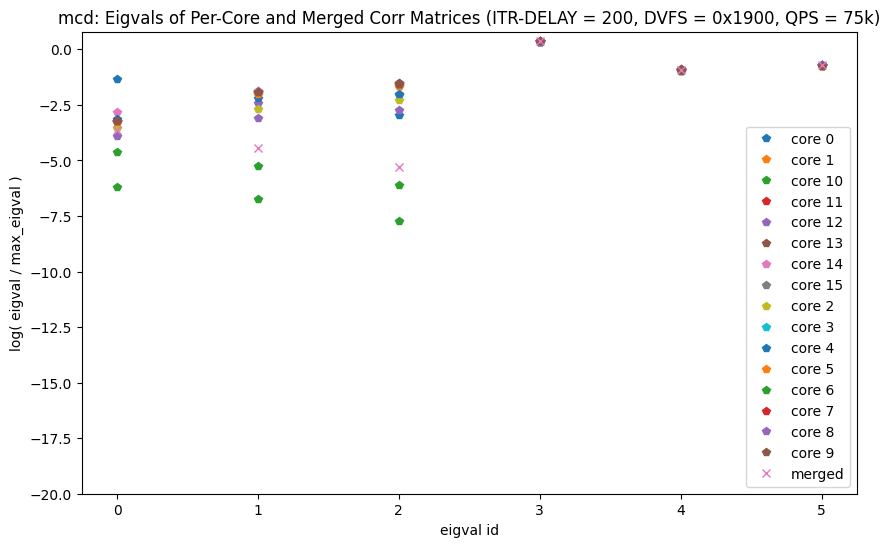


ITR-DELAY = 100,   DVFS = 0x1900,    QPS = 75k


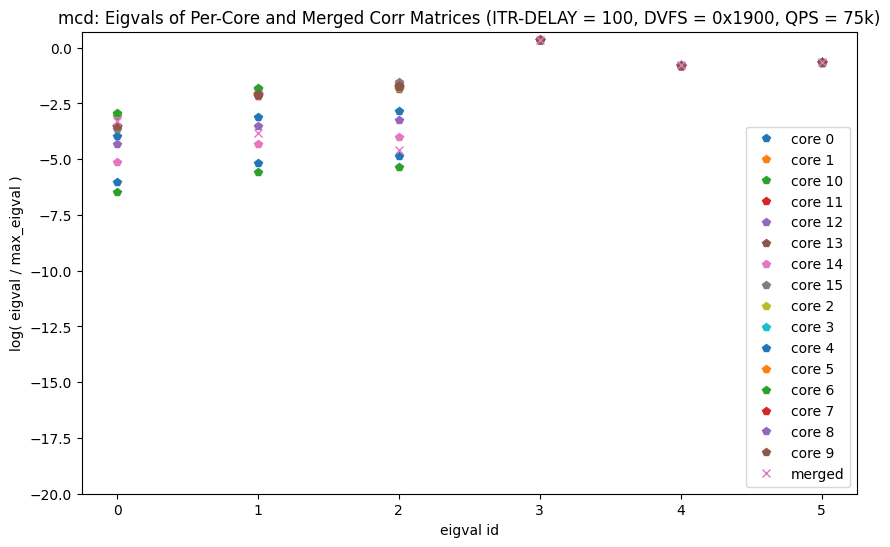


ITR-DELAY = 300,   DVFS = 0x1b00,    QPS = 75k


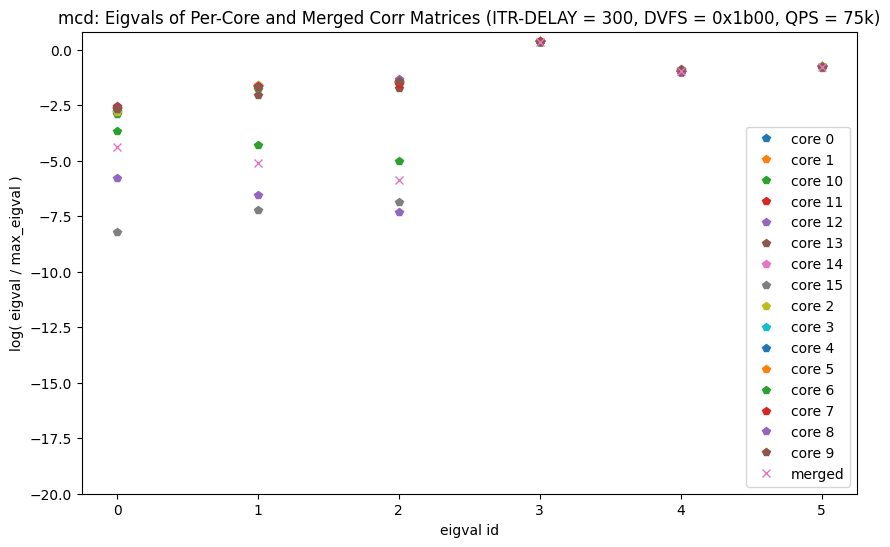


ITR-DELAY = 30,   DVFS = 0x1b00,    QPS = 75k


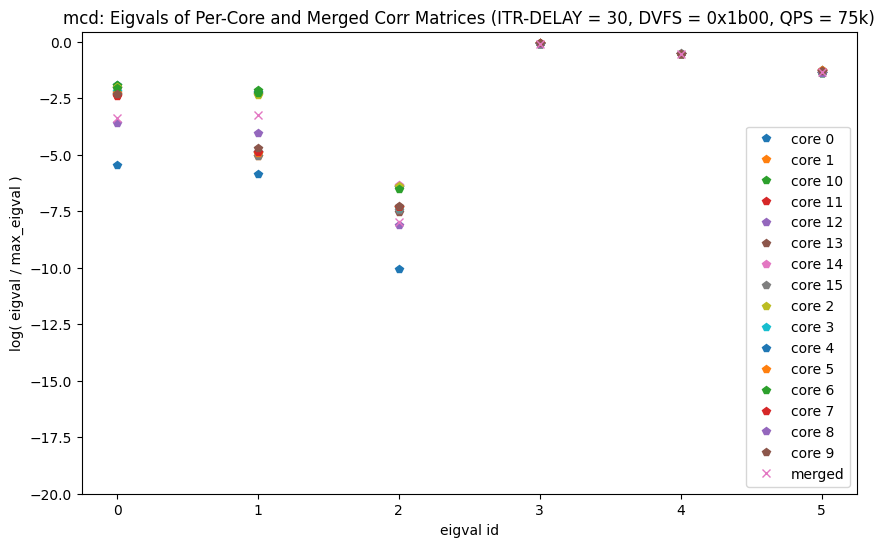


ITR-DELAY = 2,   DVFS = 0x1b00,    QPS = 75k


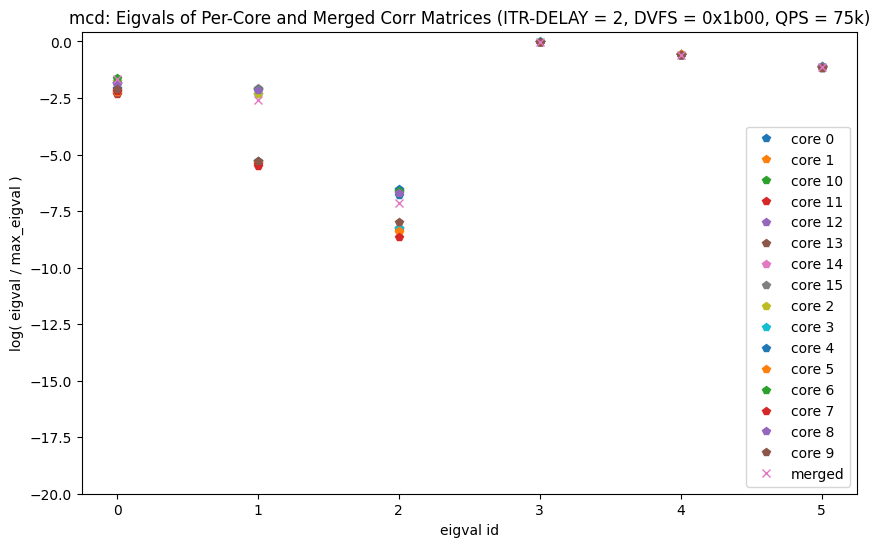


ITR-DELAY = 400,   DVFS = 0x1b00,    QPS = 75k


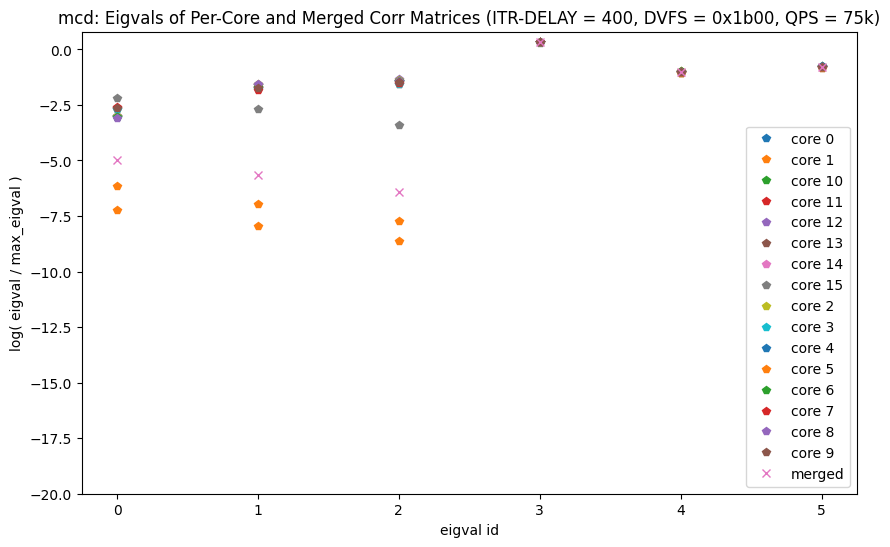


ITR-DELAY = 4,   DVFS = 0x1b00,    QPS = 75k


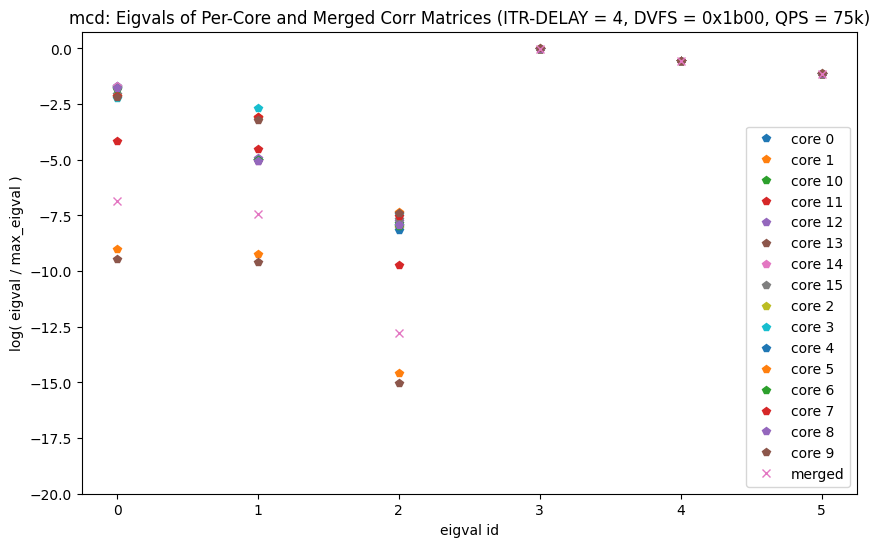


ITR-DELAY = 40,   DVFS = 0x1b00,    QPS = 75k


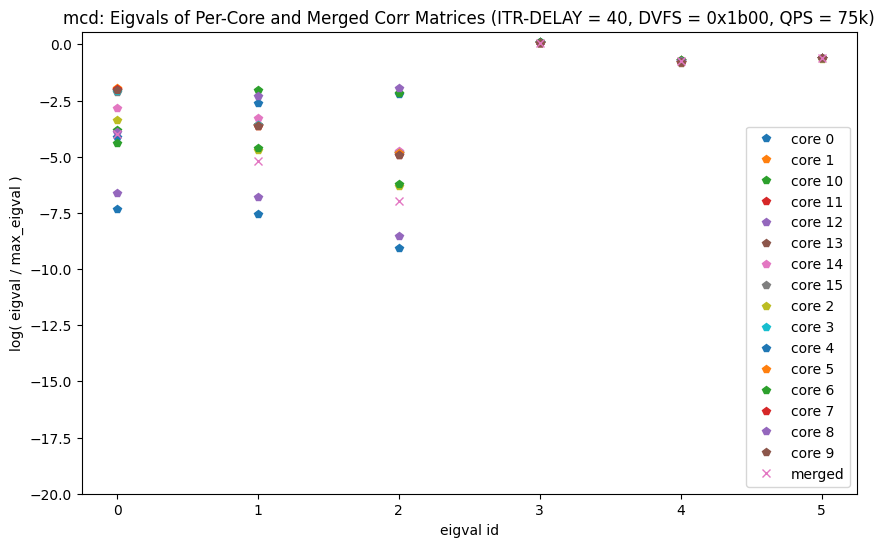


ITR-DELAY = 10,   DVFS = 0x1b00,    QPS = 75k


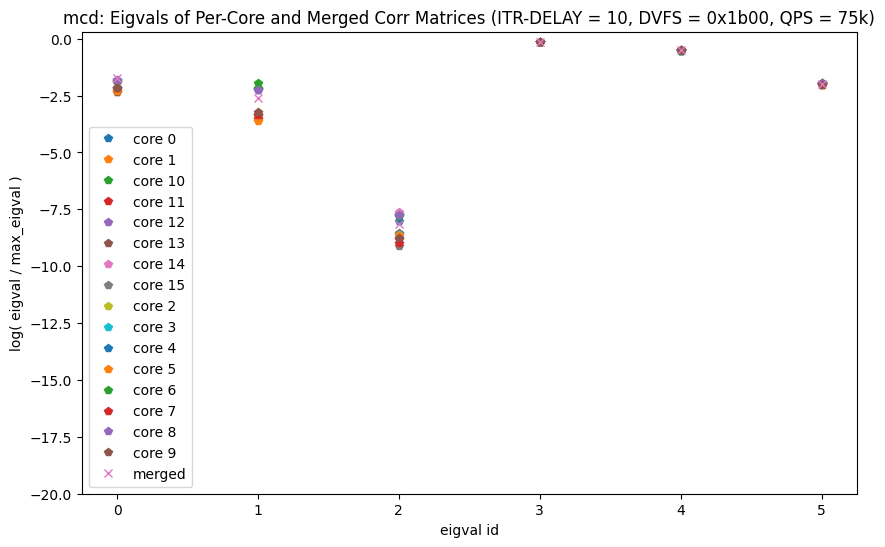


ITR-DELAY = 50,   DVFS = 0x1b00,    QPS = 75k


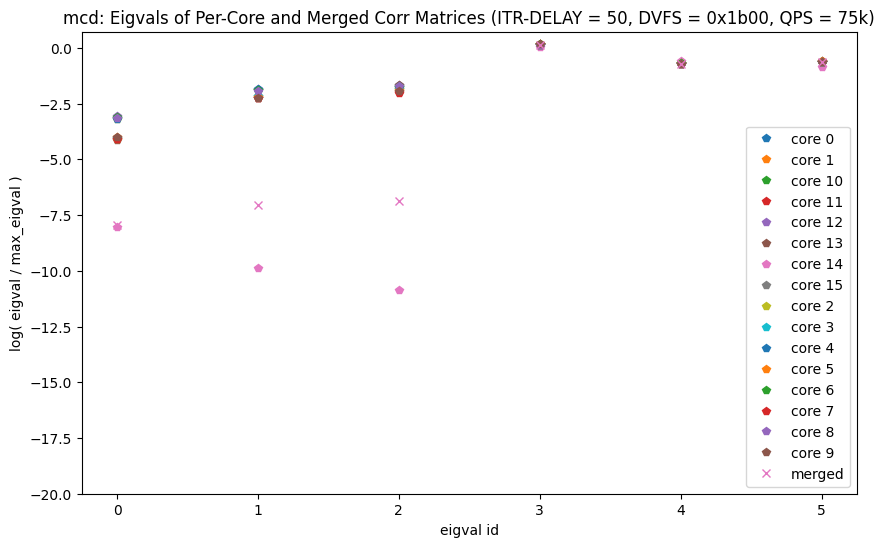


ITR-DELAY = 20,   DVFS = 0x1b00,    QPS = 75k


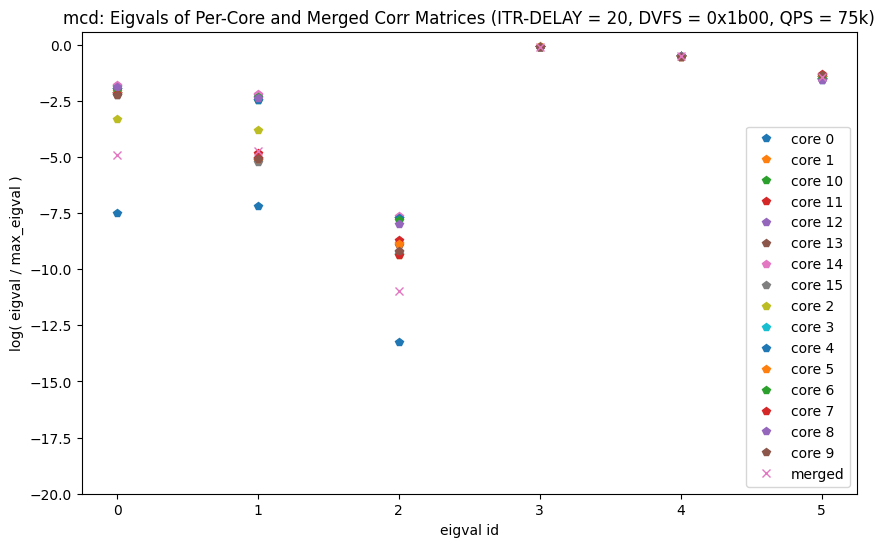


ITR-DELAY = 200,   DVFS = 0x1b00,    QPS = 75k


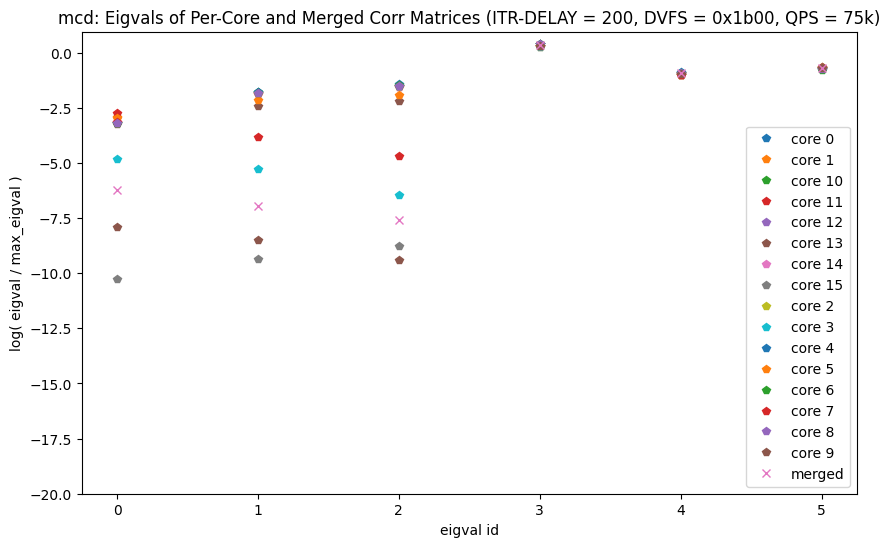


ITR-DELAY = 100,   DVFS = 0x1b00,    QPS = 75k


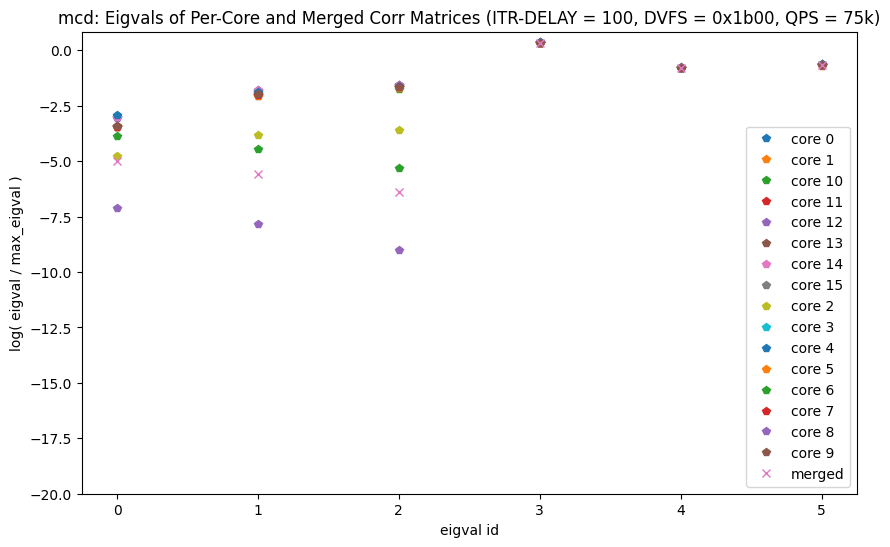


ITR-DELAY = 300,   DVFS = 0x1d00,    QPS = 75k


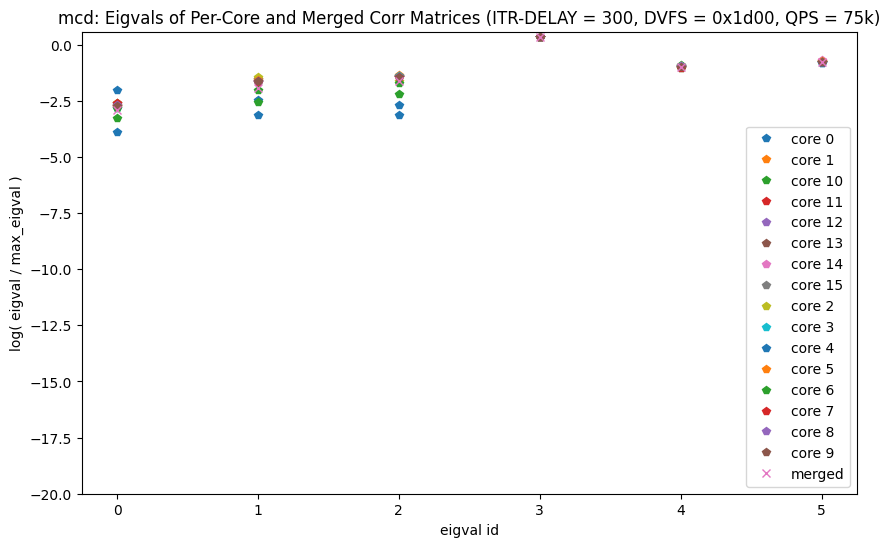


ITR-DELAY = 30,   DVFS = 0x1d00,    QPS = 75k


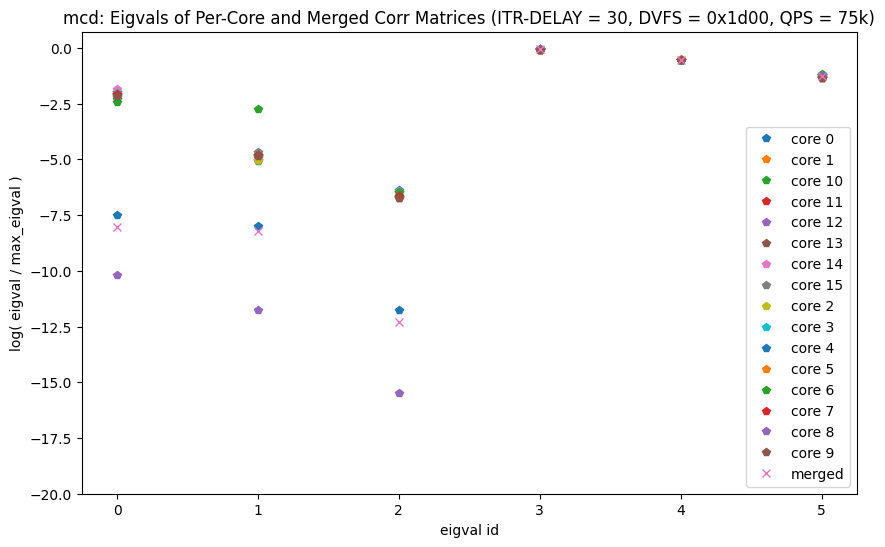


ITR-DELAY = 2,   DVFS = 0x1d00,    QPS = 75k


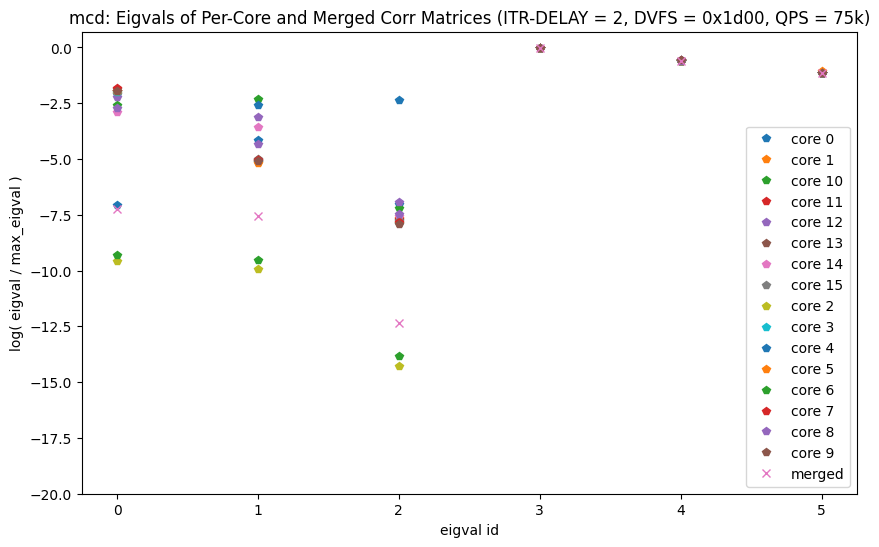


ITR-DELAY = 400,   DVFS = 0x1d00,    QPS = 75k


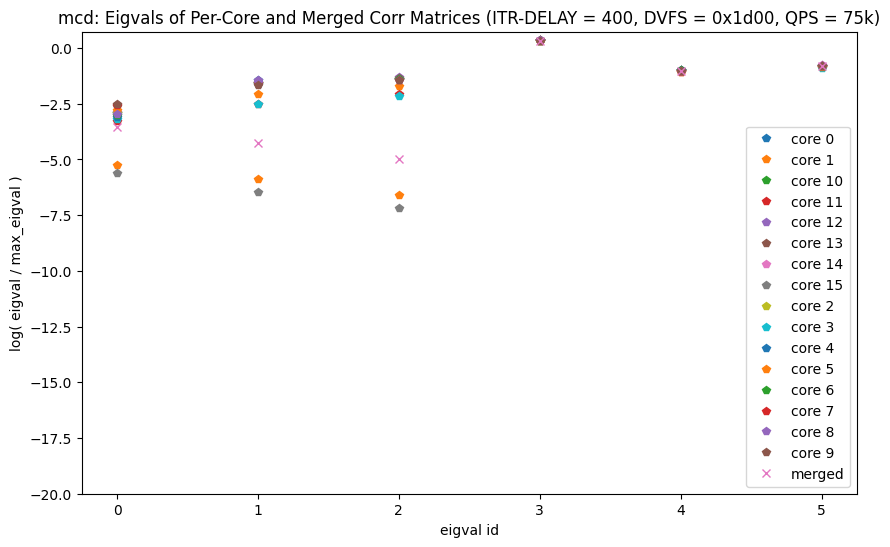


ITR-DELAY = 4,   DVFS = 0x1d00,    QPS = 75k


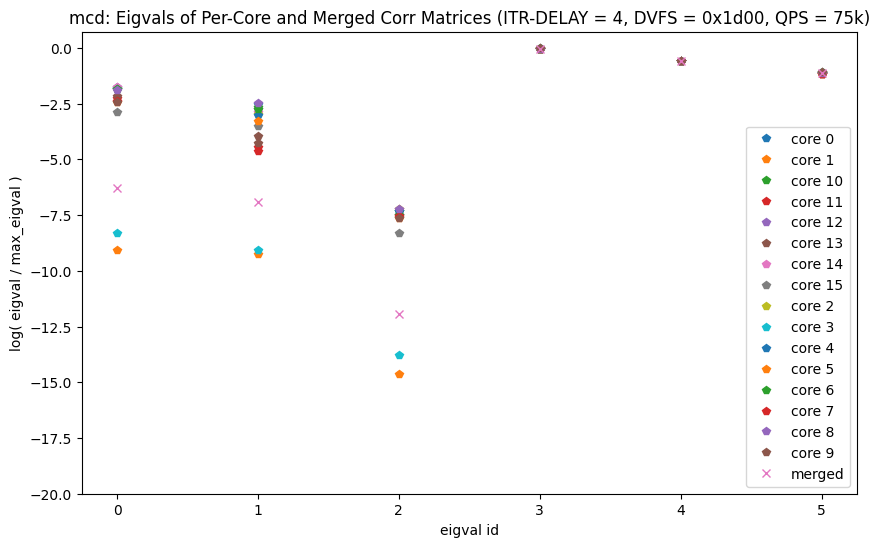


ITR-DELAY = 40,   DVFS = 0x1d00,    QPS = 75k


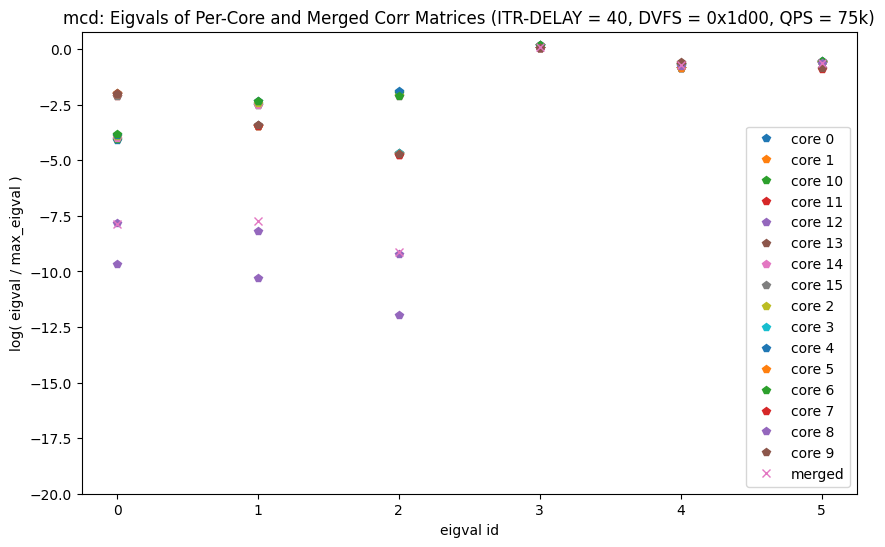


ITR-DELAY = 10,   DVFS = 0x1d00,    QPS = 75k


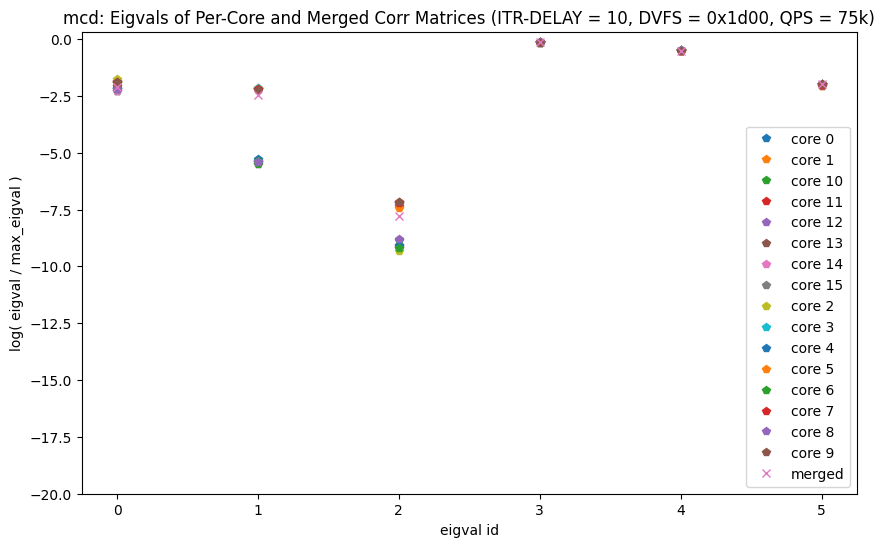


ITR-DELAY = 50,   DVFS = 0x1d00,    QPS = 75k


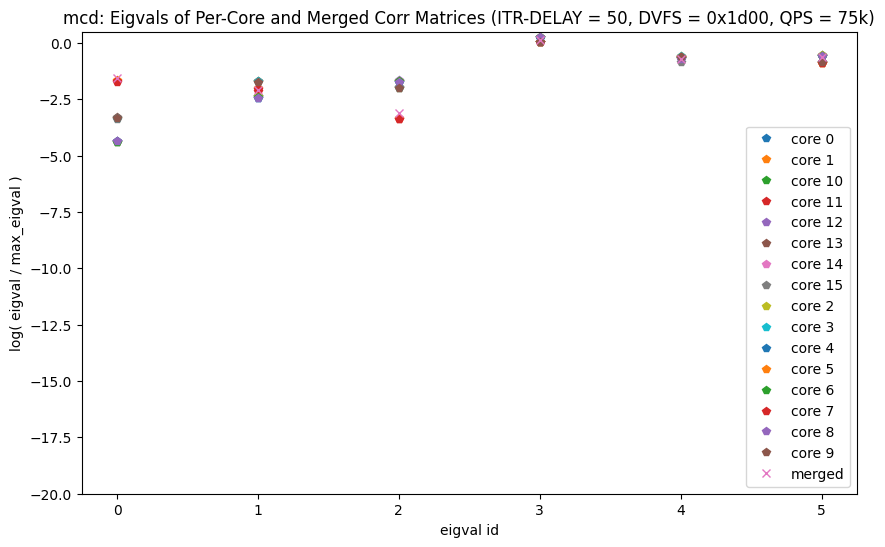


ITR-DELAY = 20,   DVFS = 0x1d00,    QPS = 75k


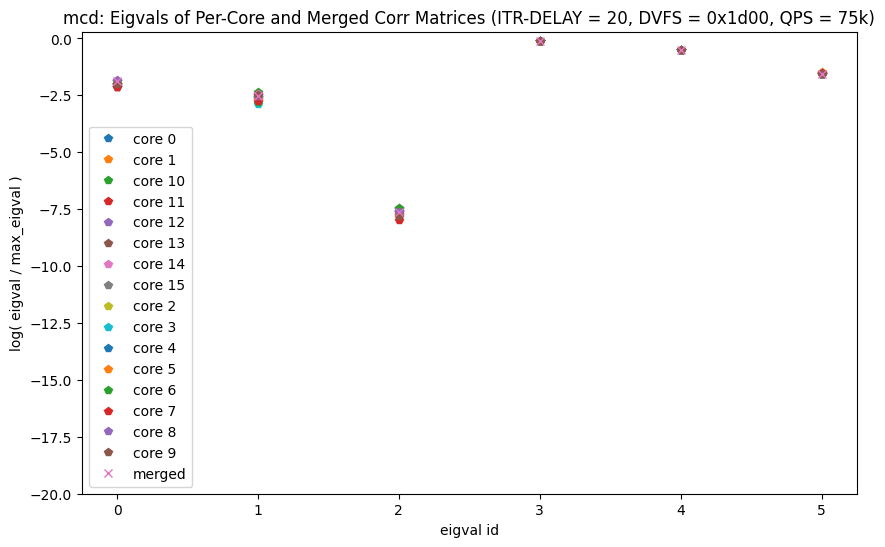


ITR-DELAY = 200,   DVFS = 0x1d00,    QPS = 75k


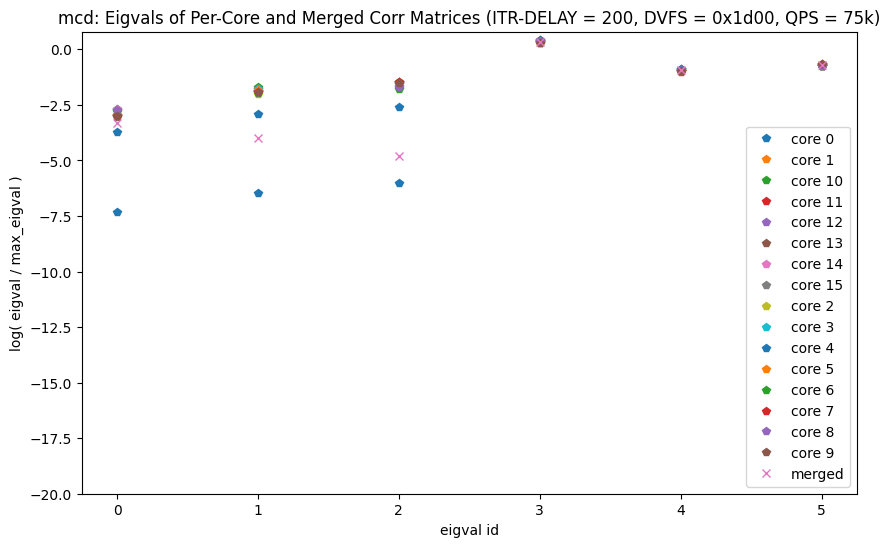


ITR-DELAY = 100,   DVFS = 0x1d00,    QPS = 75k


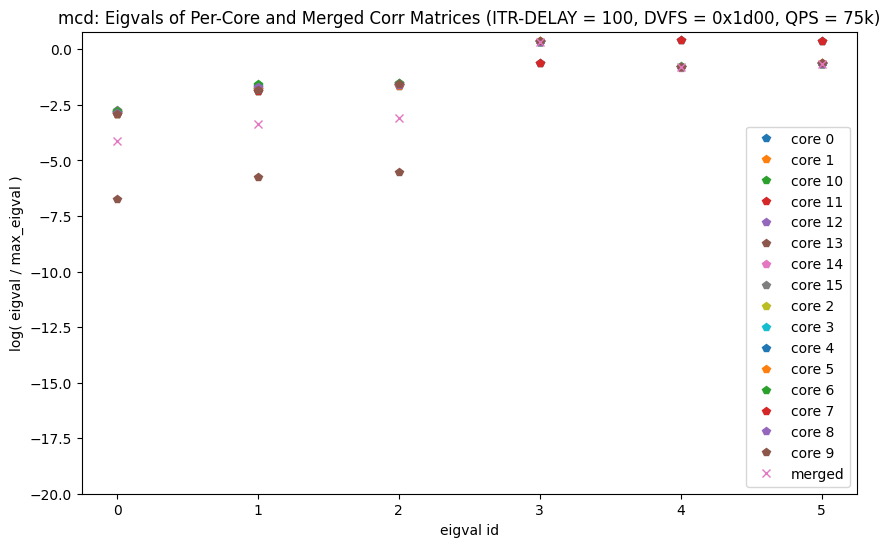

In [134]:
for dvfs in ['0xd00', '0xf00', '0x1100', '0x1300', '0x1500', '0x1700', '0x1900', '0x1b00', '0x1d00']:
#for dvfs in [dvfs]:
    for qps in [qps]:
        for itr in itrs:
            #if itr == '10':
            #    continue
            print()
            print(f'ITR-DELAY = {itr},   DVFS = {dvfs},    QPS = {qps}')
            eigvals = {}
            merged_counters_corr, merged_non_counters_corr = merged_core_corr(dvfs, qps, itr, app)
            #print(merged_counters_corr)
            if (merged_counters_corr.shape[0] == 0) or (merged_non_counters_corr.shape[0] == 0):
                continue
            counters_corr_dict, non_counters_corr_dict = per_core_corr(dvfs, qps, itr, app)
            eigvals = get_per_core_eigvals(cores, dvfs, qps, itr, app)
            eigvals['merged'] = get_merged_eigvals(dvfs, qps, itr, app)
            plot_eig_vals(eigvals, dvfs, qps, itr, app)